In [1]:
import numpy as np
import torch
import torch.nn as nn

from pfi.utils.data import load_data, X_from_snapshots
from pfi.utils.nns import SpectralNormDNN
from pfi.score import ScoreMatching
from pfi.flow import FlowRegression
from pfi.flow.models import CLEFlow, AdditiveFlow, MultiplicativeFlow, AutonomousODEFlow, ODEFlow
from pfi.flow.interpolants import ChebyshevInterpolant

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


device(type='cuda')

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

nsamples = 6000
Np = 150
Nf = 150
L = 5
fac = 2
nmb = 1
lx = 0.7


In [3]:
path = '/mnt/home/vchardes/ceph/datasets/HSC_data/10XChromiumV3_10.1038_s41467-021-27159-x_10.5281_zenodo.5291737_exvivo.h5ad'
genes = ['gata1','fli1','klf1','gata2','gfi1','gfi1b','runx1','tal1','jun','spi1','zfpm1','lmo2','etv6','erg','cebpa',\
         'meis1','sall4','myc','foxo3','zbtb7a','nanog','nfe2','stat3','mef2c']

samples, times, ind_array, cell_types = load_data(
    path=path,
    nsamples=nsamples,
    genes=genes,
    time_key='day',
    cell_type_key='cell_type',
    seed=seed,
)

X = X_from_snapshots([samples[k] for k in range(samples.shape[0])], times)
ndim = X.shape[1] - 1
print('X shape:', X.shape, 'ndim:', ndim, 'times:', times)


X shape: (36000, 25) ndim: 24 times: [ 0  2  4  6  8 11]


In [4]:
score_model = SpectralNormDNN(
    sizes=[ndim + 2, Np, Np, Np, Np, Np, ndim],
    activation=nn.ELU(),
    seed=seed,
).to(device)

score_reg = ScoreMatching(
    model=score_model,
    solver='dsm',
    solver_kwargs=dict(L=L, 
                       lr=1e-3,
                       n_epochs=6000, 
                       bs=nsamples, 
                       adp_flag=1),
    device=device,
)
score_reg.fit(X)


/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain = torch.tensor(x_train, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xdata = torch.tensor(x_data, dtype=torch.float32).to(device)
DSM:   0%|          | 7/6000 [00:00<07:17, 13.71it/s, los

epoch: 0 c_: [0.16704851 0.16466056 0.16799696 0.16706645 0.16656049 0.166667  ]


DSM:   8%|▊         | 510/6000 [00:16<02:33, 35.85it/s, loss=2.095e+00, lr=1.00e-03]

epoch: 500 c_: [0.0195698  0.13233472 0.18005008 0.24319346 0.22073592 0.20411603]


DSM:  17%|█▋        | 1008/6000 [00:32<02:23, 34.70it/s, loss=2.055e+00, lr=1.00e-03]

epoch: 1000 c_: [0.0381264  0.1317074  0.17654398 0.22530682 0.21918586 0.20912953]


DSM:  25%|██▌       | 1505/6000 [00:48<02:27, 30.53it/s, loss=2.043e+00, lr=1.00e-03]

epoch: 1500 c_: [0.0552785  0.12036084 0.17509831 0.21679576 0.21507256 0.21739401]


DSM:  34%|███▎      | 2010/6000 [01:03<01:50, 36.09it/s, loss=2.018e+00, lr=1.00e-03]

epoch: 2000 c_: [0.05098548 0.11935354 0.158106   0.22171858 0.23716168 0.21267475]


DSM:  42%|████▏     | 2508/6000 [01:19<01:41, 34.55it/s, loss=2.034e+00, lr=1.00e-04]

epoch: 2500 c_: [0.06534383 0.12558155 0.1571424  0.21209414 0.22749616 0.21234189]


DSM:  50%|█████     | 3005/6000 [01:35<01:38, 30.53it/s, loss=1.987e+00, lr=1.00e-04]

epoch: 3000 c_: [0.07107182 0.12175897 0.15678081 0.209267   0.23462296 0.20649843]


DSM:  58%|█████▊    | 3510/6000 [01:51<01:08, 36.14it/s, loss=1.980e+00, lr=1.00e-04]

epoch: 3500 c_: [0.0773941  0.11557911 0.15187071 0.20997117 0.23527408 0.20991082]


DSM:  67%|██████▋   | 4008/6000 [02:07<00:57, 34.53it/s, loss=1.972e+00, lr=1.00e-04]

epoch: 4000 c_: [0.08625887 0.1346186  0.14721684 0.19412467 0.22915047 0.20863055]


DSM:  75%|███████▌  | 4505/6000 [02:22<00:48, 30.52it/s, loss=1.970e+00, lr=1.00e-04]

epoch: 4500 c_: [0.0822715  0.12200083 0.16048542 0.2103794  0.22112341 0.20373943]


DSM:  84%|████████▎ | 5010/6000 [02:38<00:27, 36.18it/s, loss=1.970e+00, lr=1.00e-04]

epoch: 5000 c_: [0.08927931 0.13499403 0.15866427 0.20255518 0.23052825 0.18397896]


DSM:  92%|█████████▏| 5508/6000 [02:54<00:14, 34.56it/s, loss=1.966e+00, lr=1.00e-04]

epoch: 5500 c_: [0.09227556 0.12521246 0.16042301 0.20416078 0.21622495 0.20170318]


DSM: 100%|██████████| 6000/6000 [03:09<00:00, 31.60it/s, loss=1.960e+00, lr=1.00e-04]


In [5]:
# Validate score model: generated samples vs observed snapshots + ED
import matplotlib.pyplot as plt

times_eval = np.unique(X[:, -1])
ed_score = score_reg.score(X, maxiter=100)

ncols = min(4, len(times_eval))
nrows = int(np.ceil(len(times_eval) / ncols))
#fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
gen = []
xks = []

for k, t in enumerate(times_eval):
    xk = X[X[:, -1] == t]
    xks.append(xk)
    gen.append(score_reg.sample(xk, nsamples=xk.shape[0], maxiter=100))


/mnt/home/vchardes/pfi/pfi/score/_base.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = torch.tensor(init_, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/_base.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_t, dtype=torch.float32, device=self.device),


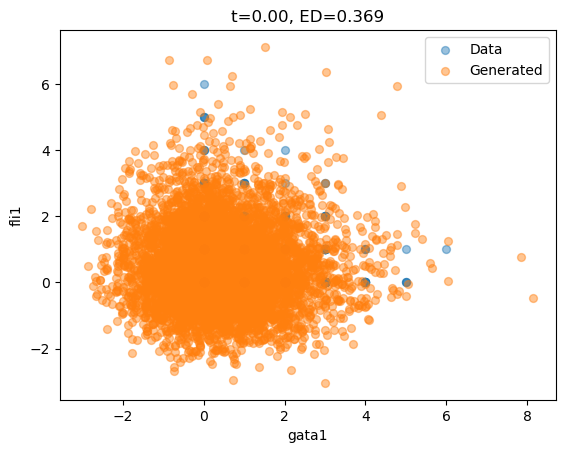

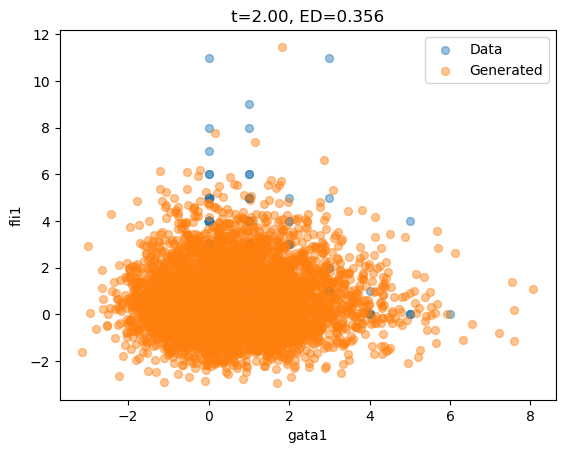

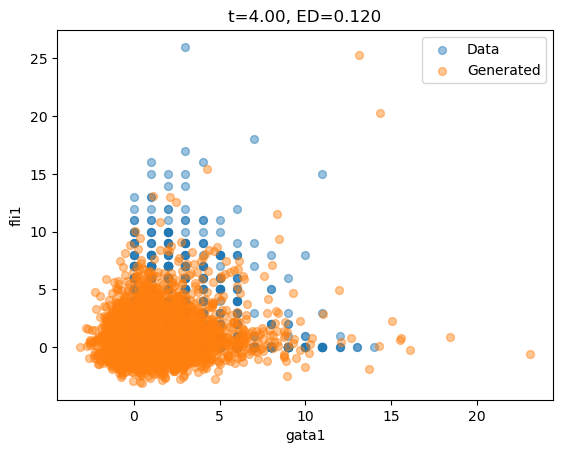

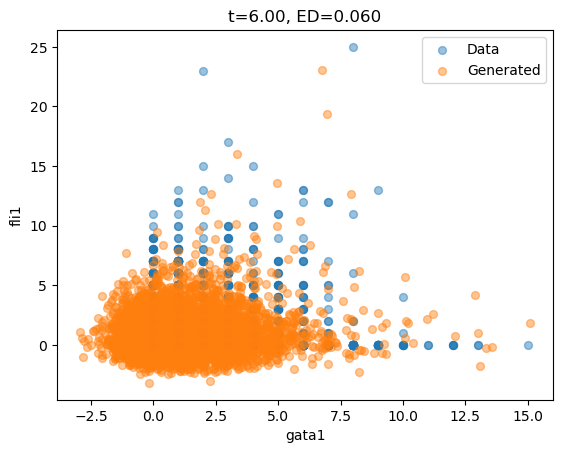

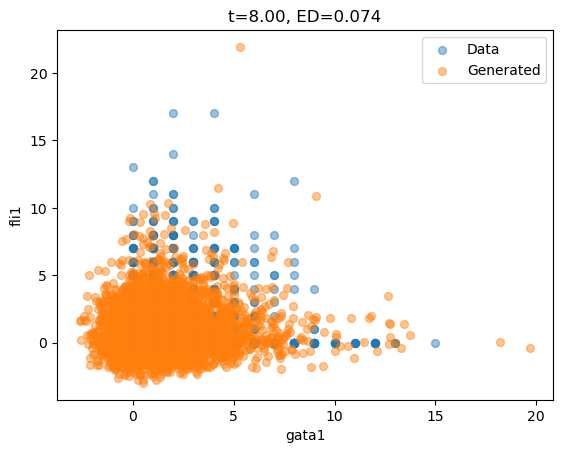

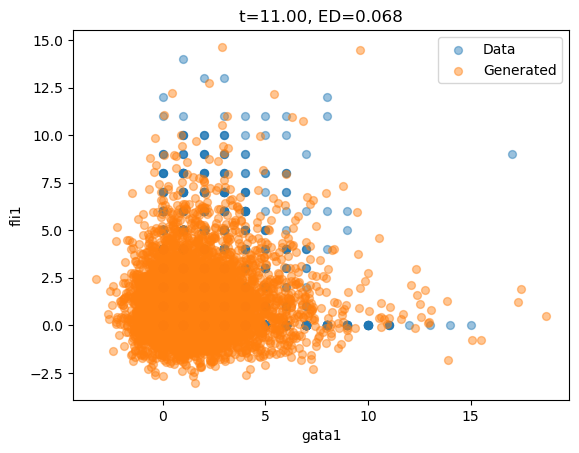

ED per time: [0.36944389 0.3558054  0.11985683 0.05957985 0.07408667 0.06780815]


In [6]:

for k, t in enumerate(times_eval):

    xk = X[X[:, -1] == t]
    fig, ax = plt.subplots()
    ax.scatter(xk[:, 0], xk[:, 1], s=32, alpha=0.45, label='Data')
    ax.scatter(gen[k][:, 0], gen[k][:, 1], s=32, alpha=0.45, label='Generated')
    ax.set_title(f't={t:.2f}, ED={ed_score[k]:.3f}')
    ax.set_xlabel(genes[0])
    ax.set_ylabel(genes[1])
    ax.legend(loc='best')

plt.show()

print('ED per time:', ed_score)


In [7]:
flow_builders = {
    'cle': lambda net: CLEFlow(net=net, score=score_reg.model_, Ndim=ndim, lx=lx),
    'additive': lambda net: AdditiveFlow(net=net, score=score_reg.model_, Ndim=ndim, lx=lx, 
                                         D=0.5*torch.eye(ndim, device=device, dtype=torch.float32)),
    'multiplicative': lambda net: MultiplicativeFlow(net=net, score=score_reg.model_, Ndim=ndim, lx=lx),
    'autonomous_ode': lambda net: AutonomousODEFlow(net=net, score=score_reg.model_, Ndim=ndim, lx=lx),
}

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

flow_regs = {}
for model_name, build_model in flow_builders.items():
    input = ndim
    drift_model = SpectralNormDNN(
        sizes=[ndim, Nf, Nf, Nf, Nf, ndim],
        activation=nn.ELU(),
        seed=seed
    ).to(device)

    flow_reg = FlowRegression(
        interp=ChebyshevInterpolant(device=device),
        model=build_model(drift_model),
        growth_model=None,
        solver='fm',
        solver_kwargs=dict(fac=4, 
                           nb=nmb,
                           n_epochs=2000, 
                           lr=1e-3),
        device=device,
    )
    flow_reg.fit(X)
    flow_regs[model_name] = flow_reg


6000 1500
[lambda-selection] Initial error: 0.1378
[lambda-selection] Best lambda (>=80% drop): 0.8000
[lambda-selection] Vel magnitudes: [0.13780634 0.12786806 0.11962548 0.11002904 0.09282199 0.07746615
 0.0684326  0.06215395 0.04764389 0.03969438 0.03441904 0.03060517
 0.02355716 0.02071998]


FM:   0%|          | 0/2000 [00:00<?, ?it/s]/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:299: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Dist = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:300: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32, device=device)
FM:   0%|          | 1/2000 [00:00<04:30,  7.38it/s, loss=2.860e-01, lr=1.00e-03]

[epoch 0] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  25%|██▌       | 503/2000 [00:42<02:05, 11.91it/s, loss=8.681e-03, lr=1.00e-03]

[epoch 500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  50%|█████     | 1003/2000 [01:24<01:23, 11.89it/s, loss=6.996e-03, lr=1.00e-04]

[epoch 1000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  75%|███████▌  | 1503/2000 [02:05<00:41, 11.89it/s, loss=6.828e-03, lr=1.00e-05]

[epoch 1500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 2000/2000 [02:47<00:00, 11.94it/s, loss=6.685e-03, lr=1.00e-05]


6000 1500
[lambda-selection] Initial error: 0.1378
[lambda-selection] Best lambda (>=80% drop): 0.8000
[lambda-selection] Vel magnitudes: [0.13780634 0.12786806 0.11962548 0.11002904 0.09282199 0.07746615
 0.0684326  0.06215395 0.04764389 0.03969438 0.03441904 0.03060517
 0.02355716 0.02071998]


FM:   0%|          | 9/2000 [00:00<00:22, 86.57it/s, loss=1.508e-01, lr=1.00e-03]

[epoch 0] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  26%|██▌       | 513/2000 [00:05<00:14, 99.36it/s, loss=9.794e-03, lr=1.00e-03] 

[epoch 500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  51%|█████     | 1011/2000 [00:10<00:09, 99.36it/s, loss=6.922e-03, lr=1.00e-04]

[epoch 1000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  76%|███████▌  | 1518/2000 [00:15<00:04, 99.49it/s, loss=6.372e-03, lr=1.00e-05] 

[epoch 1500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 2000/2000 [00:20<00:00, 99.96it/s, loss=6.691e-03, lr=1.00e-05] 


6000 1500
[lambda-selection] Initial error: 0.1378
[lambda-selection] Best lambda (>=80% drop): 0.8000
[lambda-selection] Vel magnitudes: [0.13780634 0.12786806 0.11962548 0.11002904 0.09282199 0.07746615
 0.0684326  0.06215395 0.04764389 0.03969438 0.03441904 0.03060517
 0.02355716 0.02071998]


FM:   0%|          | 10/2000 [00:00<00:21, 90.59it/s, loss=1.318e-01, lr=1.00e-03]

[epoch 0] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  26%|██▌       | 519/2000 [00:05<00:14, 99.03it/s, loss=1.321e-02, lr=1.00e-03] 

[epoch 500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  51%|█████     | 1020/2000 [00:10<00:09, 98.75it/s, loss=1.124e-02, lr=1.00e-04]

[epoch 1000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  76%|███████▌  | 1511/2000 [00:15<00:04, 98.15it/s, loss=1.052e-02, lr=1.00e-05]

[epoch 1500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 2000/2000 [00:20<00:00, 99.42it/s, loss=1.005e-02, lr=1.00e-05] 


6000 1500
[lambda-selection] Initial error: 0.1378
[lambda-selection] Best lambda (>=80% drop): 0.8000
[lambda-selection] Vel magnitudes: [0.13780634 0.12786806 0.11962548 0.11002904 0.09282199 0.07746615
 0.0684326  0.06215395 0.04764389 0.03969438 0.03441904 0.03060517
 0.02355716 0.02071998]


FM:   1%|          | 11/2000 [00:00<00:19, 103.58it/s, loss=1.980e-01, lr=1.00e-03]

[epoch 0] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  26%|██▌       | 514/2000 [00:04<00:12, 116.09it/s, loss=6.740e-03, lr=1.00e-03]

[epoch 500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  51%|█████     | 1018/2000 [00:08<00:08, 116.30it/s, loss=5.199e-03, lr=1.00e-04]

[epoch 1000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  76%|███████▌  | 1522/2000 [00:13<00:04, 116.34it/s, loss=4.717e-03, lr=1.00e-05]

[epoch 1500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 2000/2000 [00:17<00:00, 116.52it/s, loss=4.983e-03, lr=1.00e-05]


Interpolation ED (cle, ex vivo t0 -> t>0): [0.53063536 0.29769468 0.17892313 0.28011656 0.22925425]
Interpolation mean ED (cle): 0.3033247947692871
Interpolation ED (additive, ex vivo t0 -> t>0): [ 3.08220863  3.67643642  6.59855652  9.07354164 10.4896841 ]
Interpolation mean ED (additive): 6.584085464477539
Interpolation ED (multiplicative, ex vivo t0 -> t>0): [1.08269548 0.56743717 0.97422218 1.68482351 1.86973286]
Interpolation mean ED (multiplicative): 1.2357822418212892
Interpolation ED (autonomous_ode, ex vivo t0 -> t>0): [0.28206062 0.48973036 0.16429472 0.04483652 0.04183722]
Interpolation mean ED (autonomous_ode): 0.20455188751220704


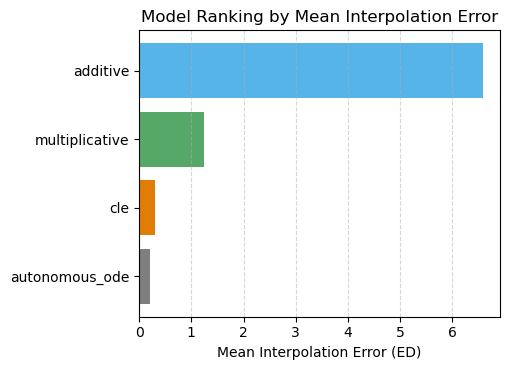

In [8]:
# Stochastic interpolation
import matplotlib.pyplot as plt

t_ex = np.sort(np.unique(X[:, -1]))
t0_ex = t_ex[0]
X0_ex = X[np.isclose(X[:, -1], t0_ex)]
interp_errors = {}
for name, reg in flow_regs.items():
    ed = []
    for ty in t_ex[1:]:
        y_t = X[np.isclose(X[:, -1], ty)]
        ed.append(reg.score(X0_ex, y_t, stoch=True, dt=1e-2)[0])
    interp_errors[name] = np.asarray(ed)

mean_interp_errors = {name: float(np.mean(ed)) for name, ed in interp_errors.items()}
for name, ed in interp_errors.items():
    print(f'Interpolation ED ({name}, ex vivo t0 -> t>0):', ed)
    print(f'Interpolation mean ED ({name}):', mean_interp_errors[name])

# Ranked mean interpolation error (same style as Generalization_results_exvivo)
sorted_items = sorted(mean_interp_errors.items(), key=lambda x: x[1])
methods_sorted, means_sorted = zip(*sorted_items)

base_colors = {
    'cle': '#E17C05',
    'additive': '#56B4E9',
    'multiplicative': '#55A868',
}
colors_sorted = [base_colors.get(m, '#7F7F7F') for m in methods_sorted]

fig, ax = plt.subplots(figsize=(5.2, 3.8))
ax.barh(methods_sorted, means_sorted, color=colors_sorted)
ax.set_xlabel('Mean Interpolation Error (ED)')
ax.set_title('Model Ranking by Mean Interpolation Error')
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Top-6 variable genes: ['jun', 'myc', 'gata1', 'mef2c', 'runx1', 'klf1']


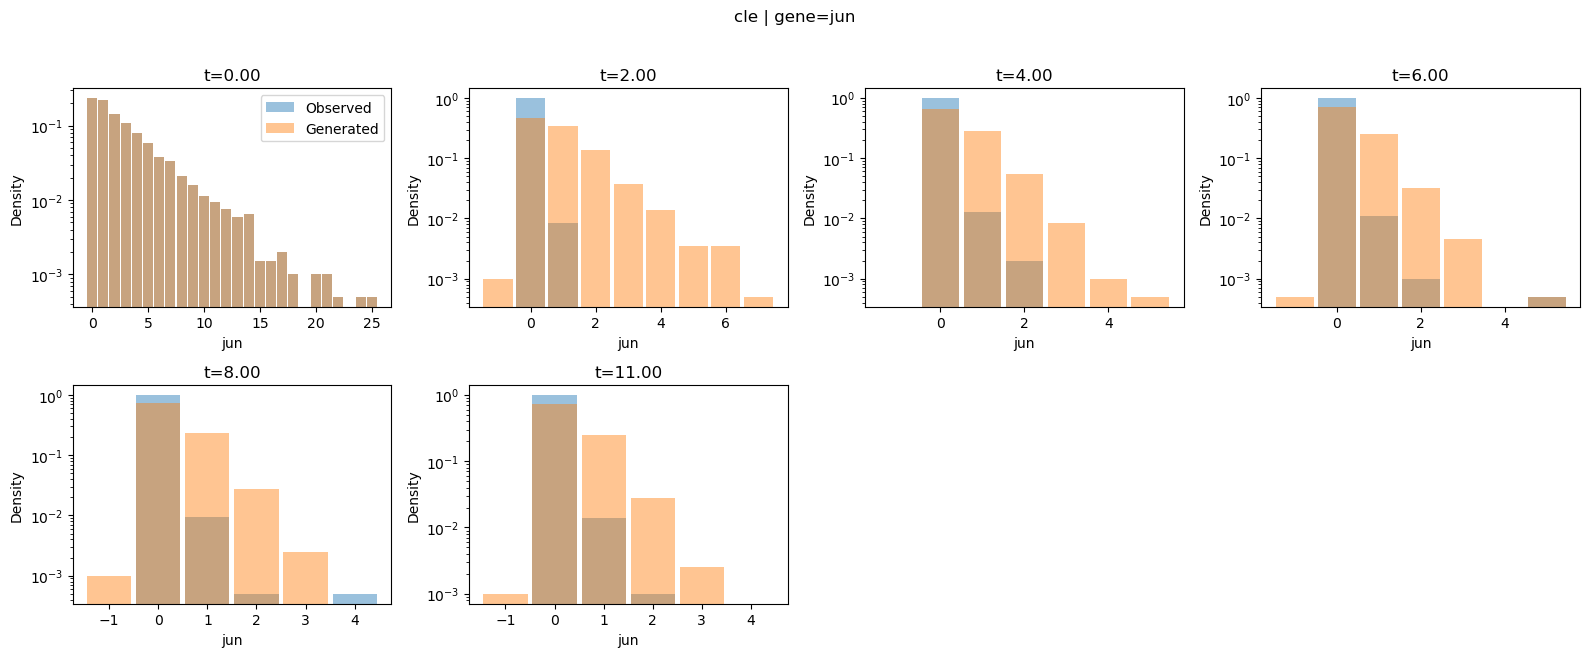

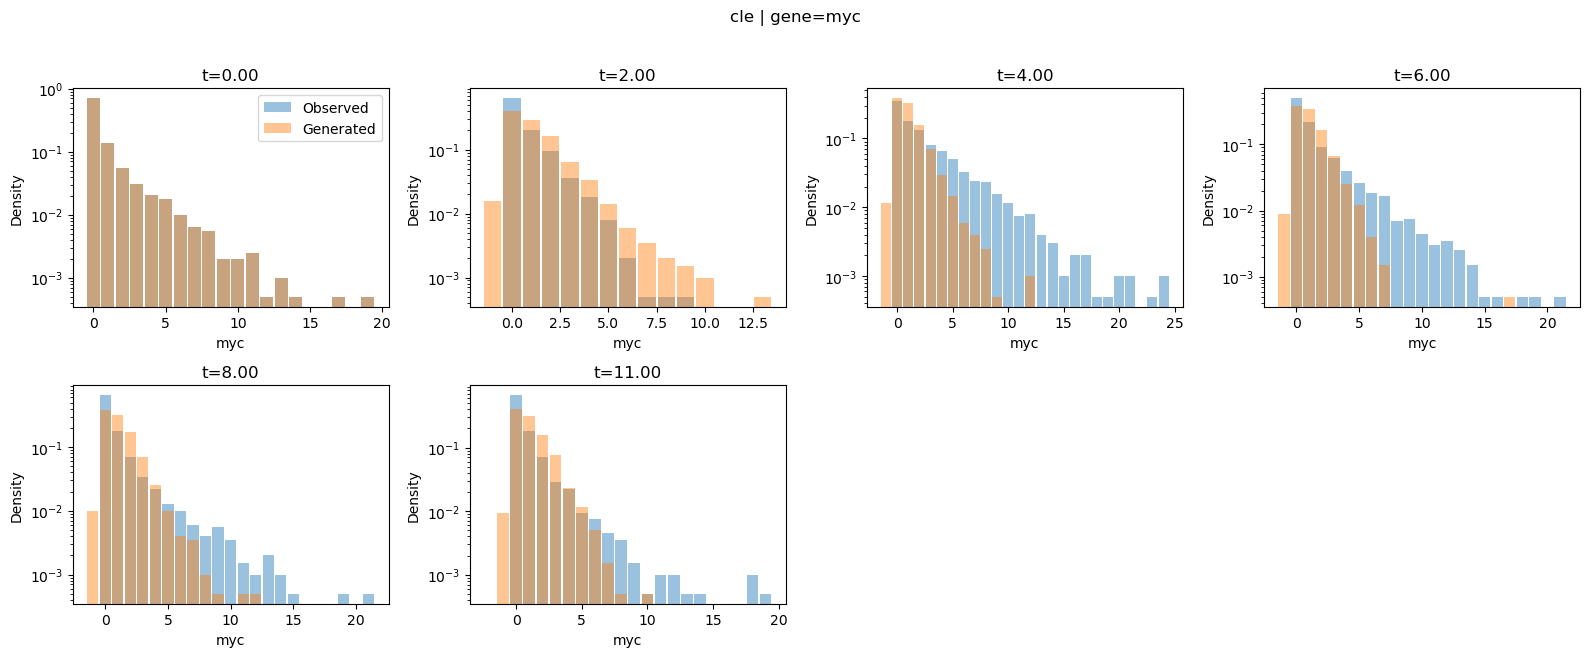

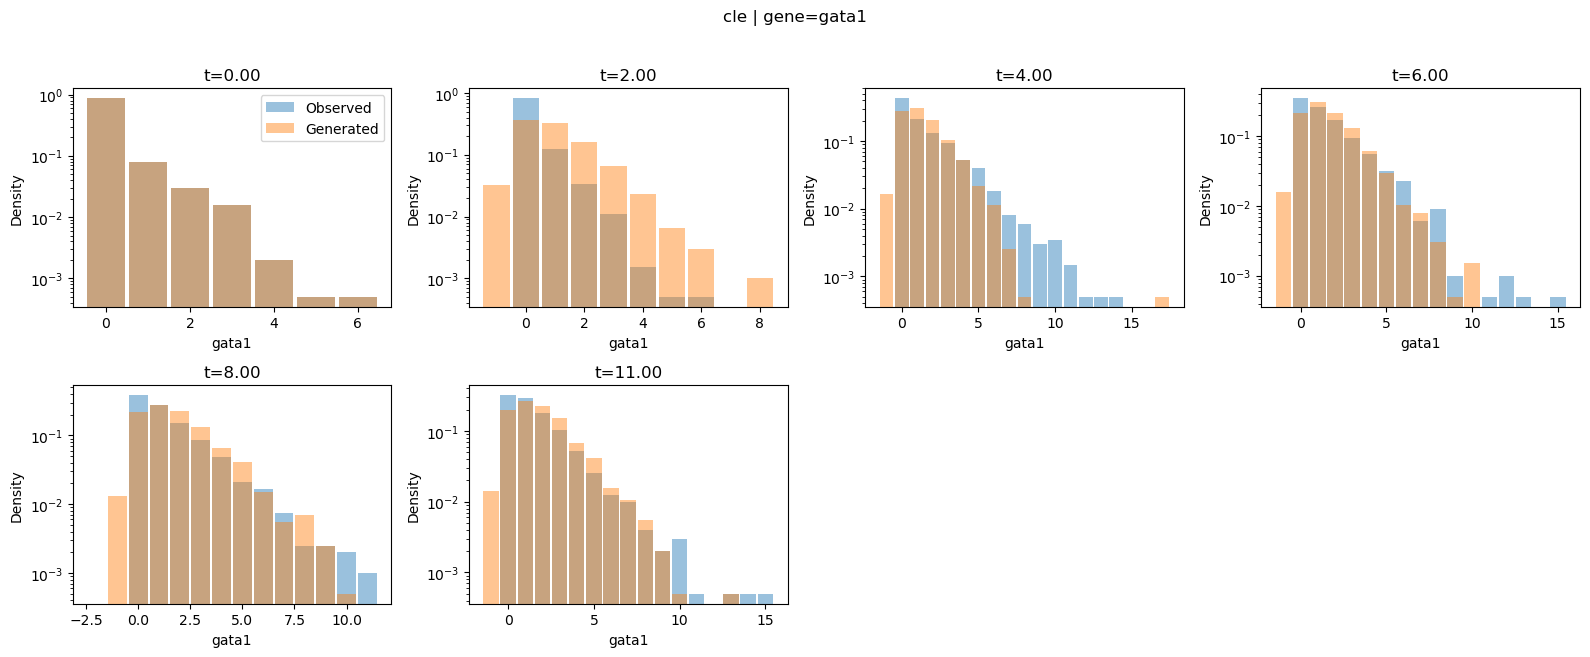

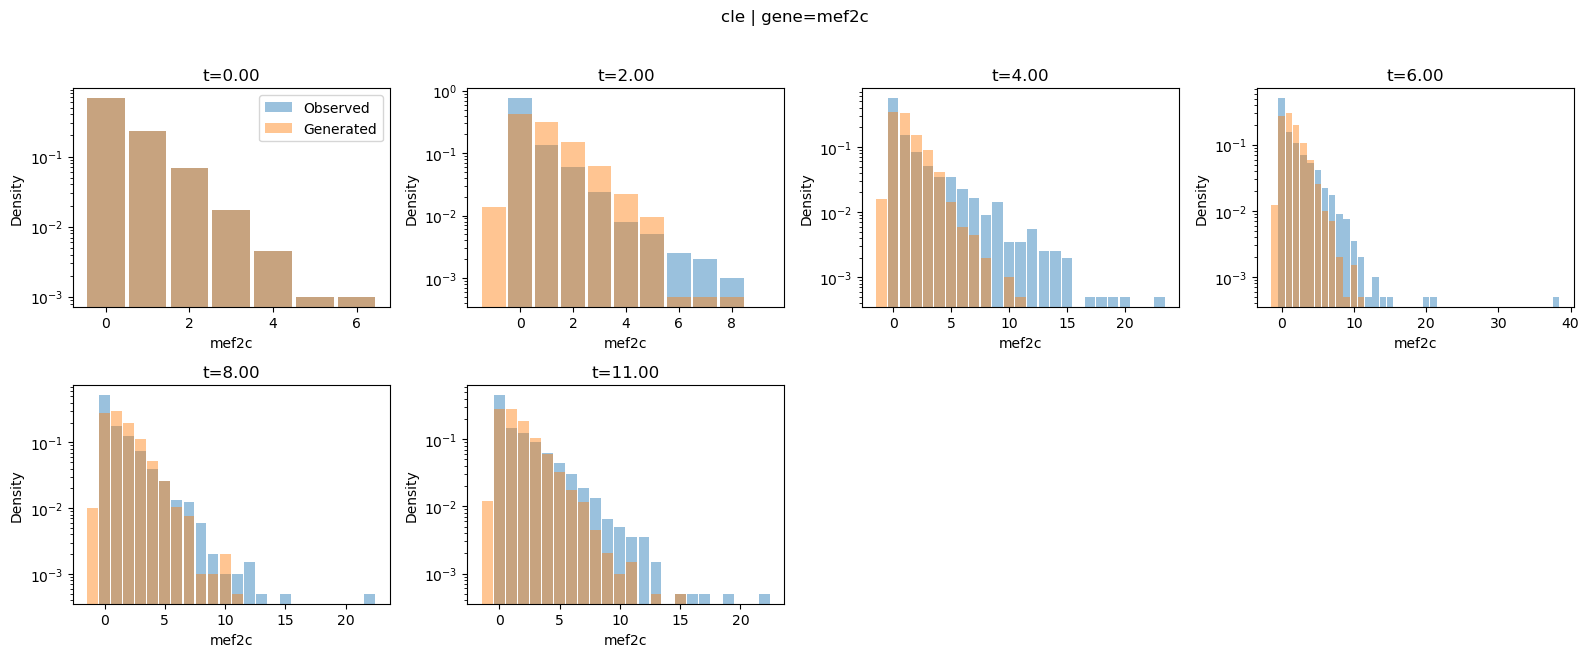

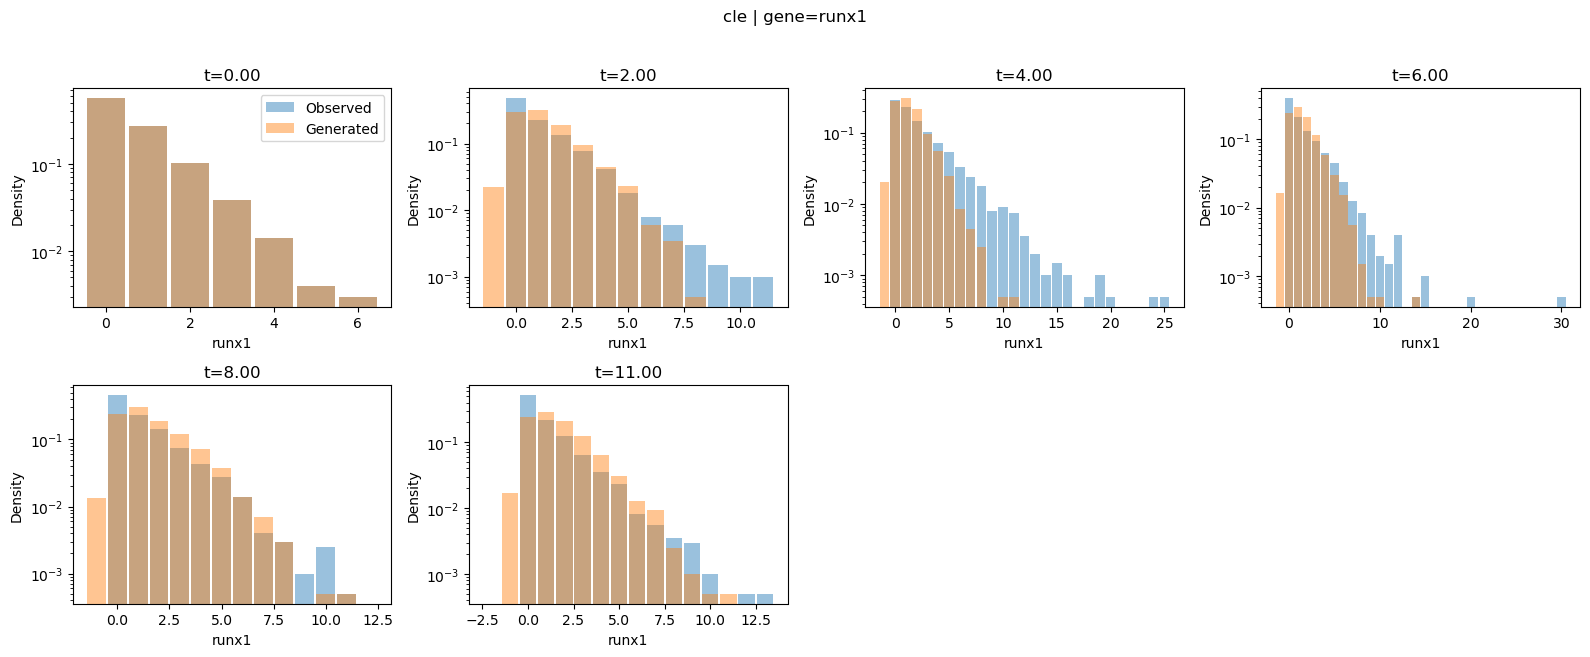

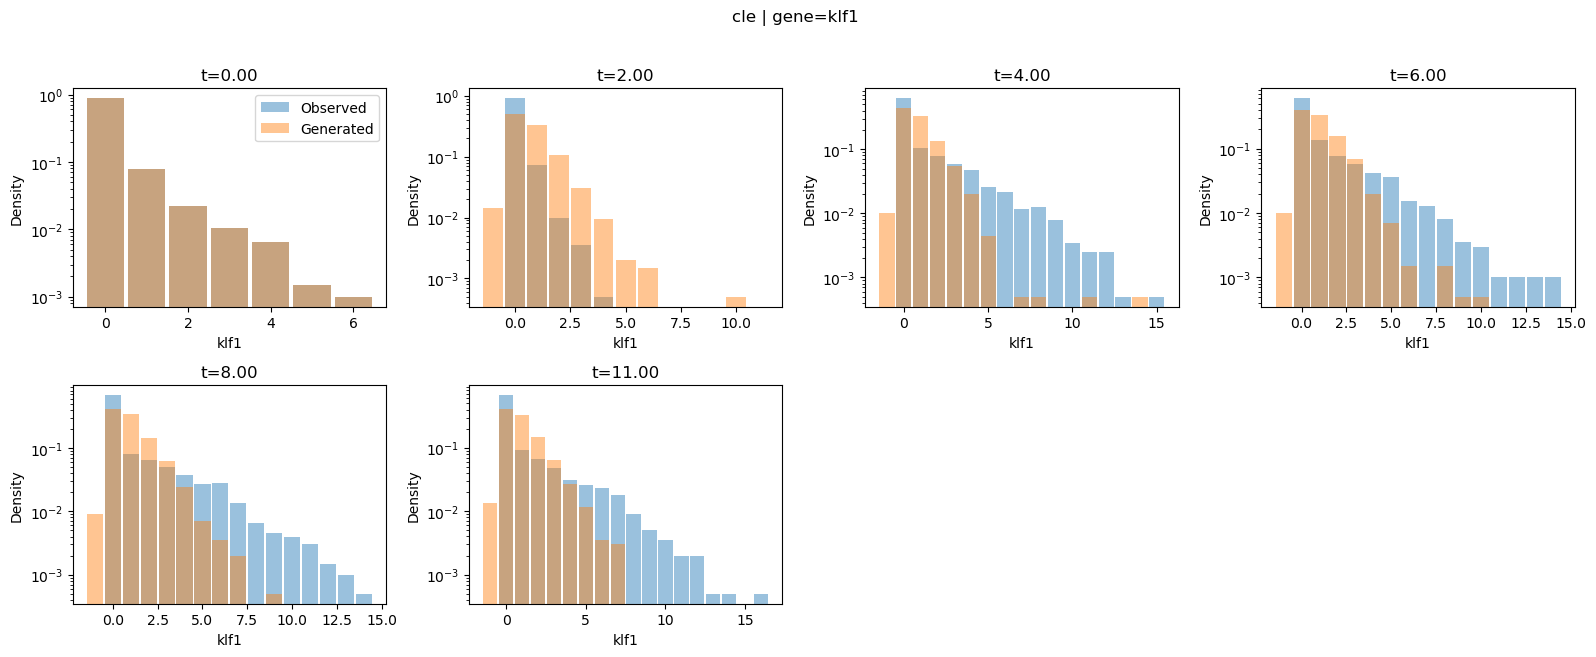

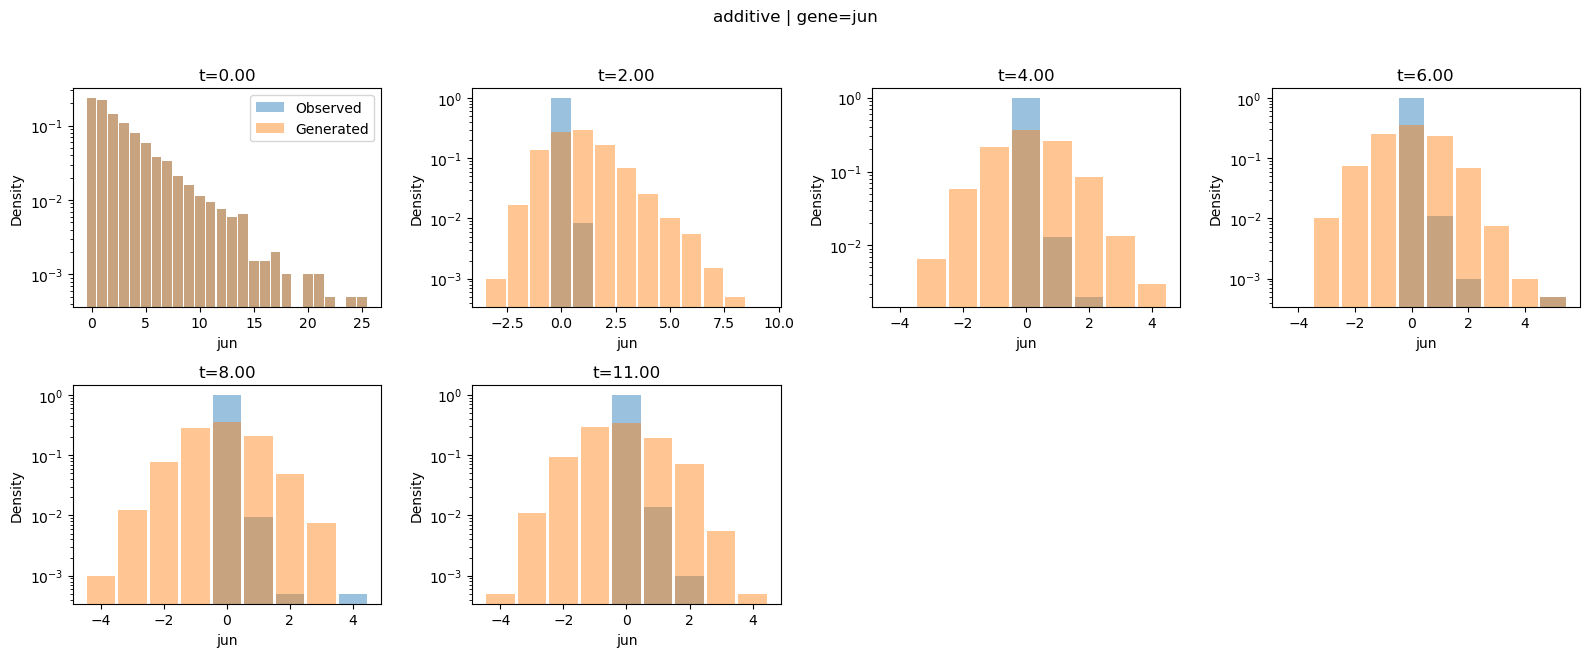

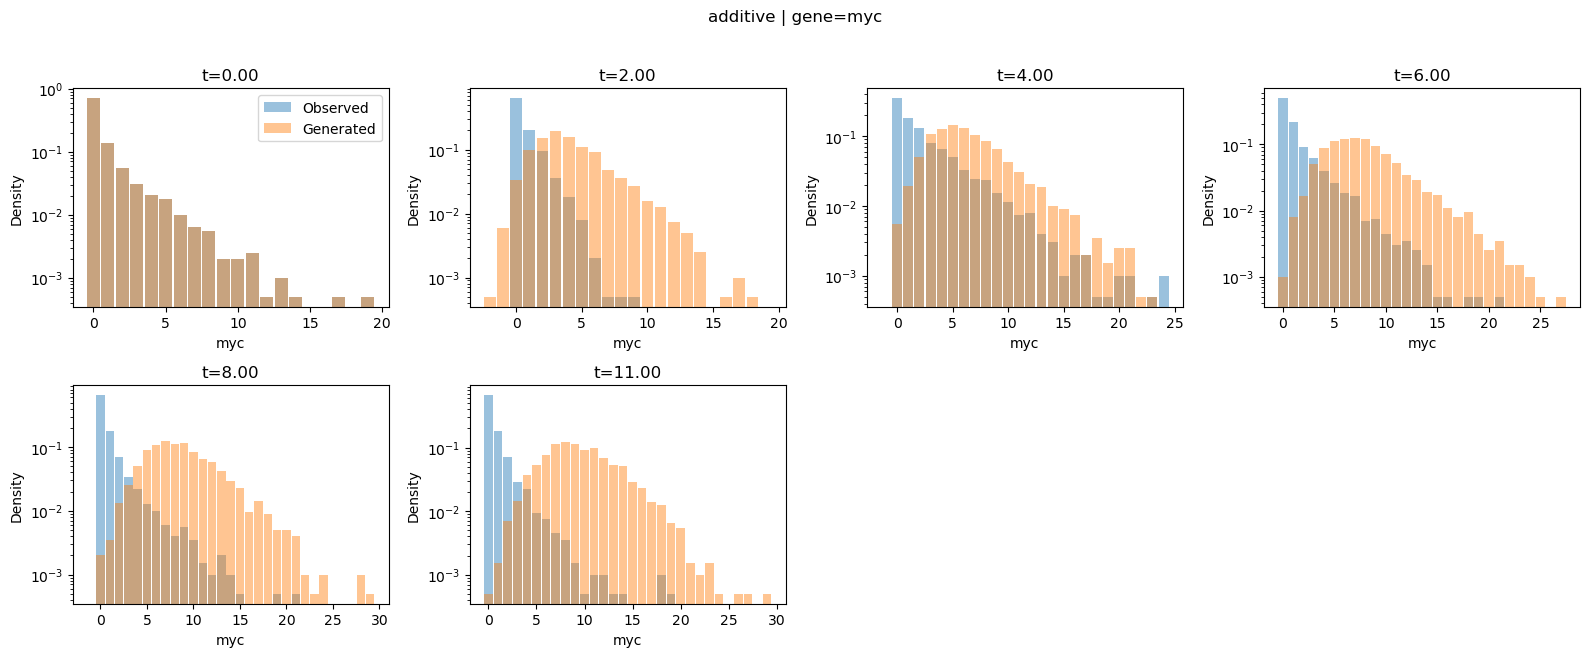

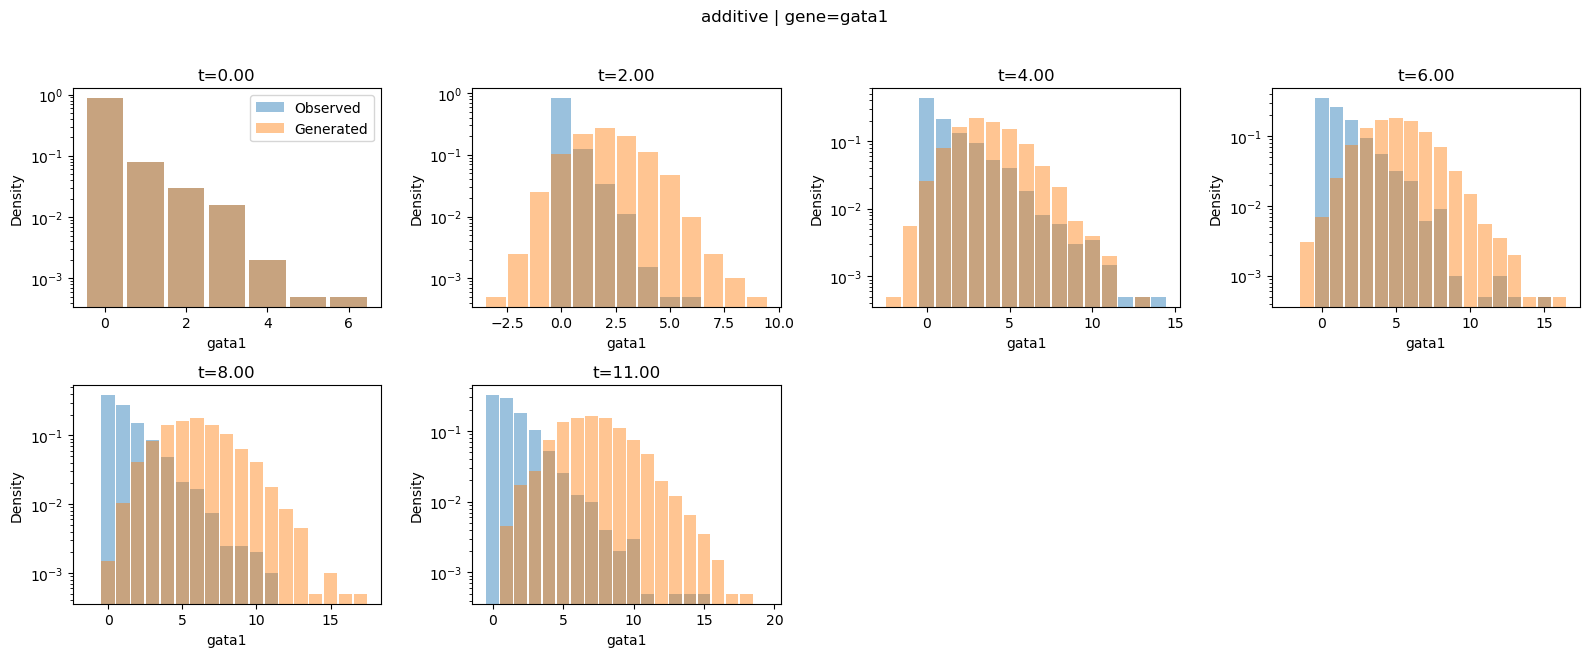

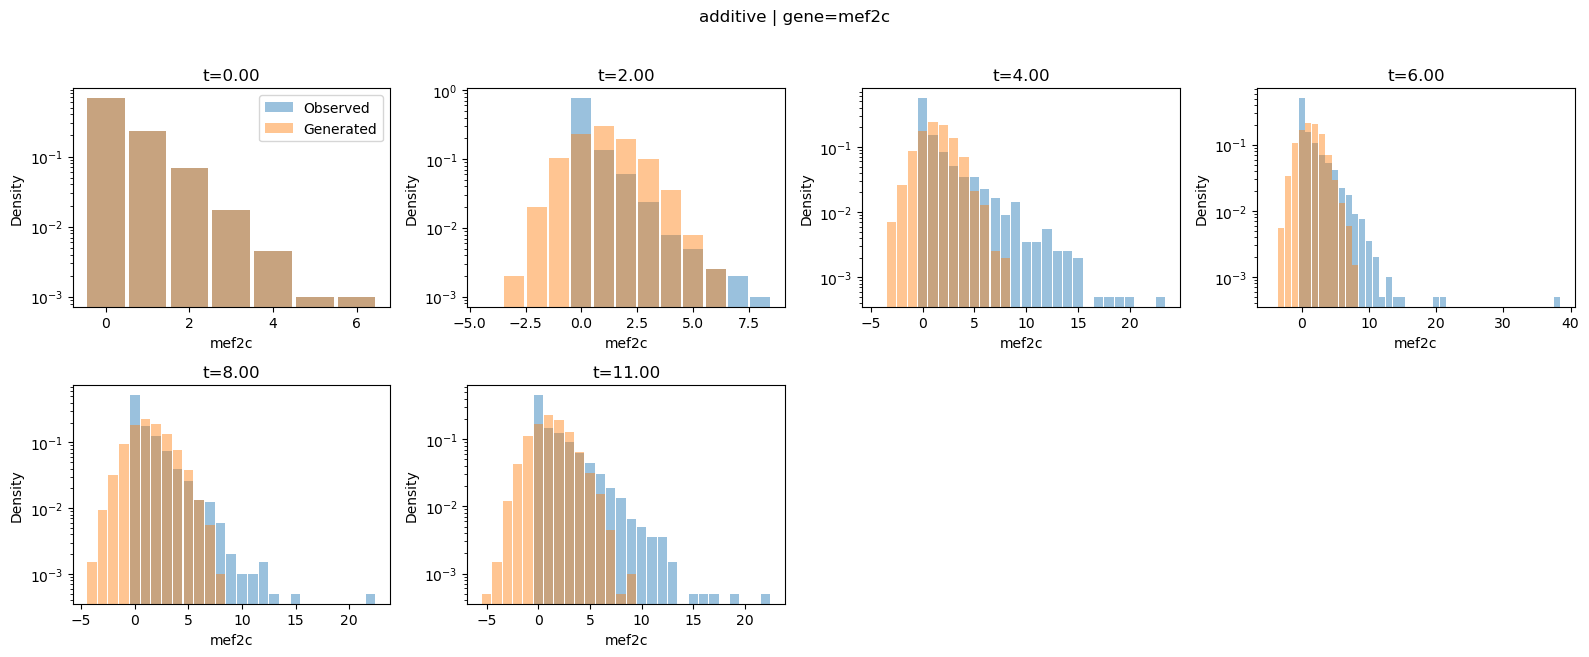

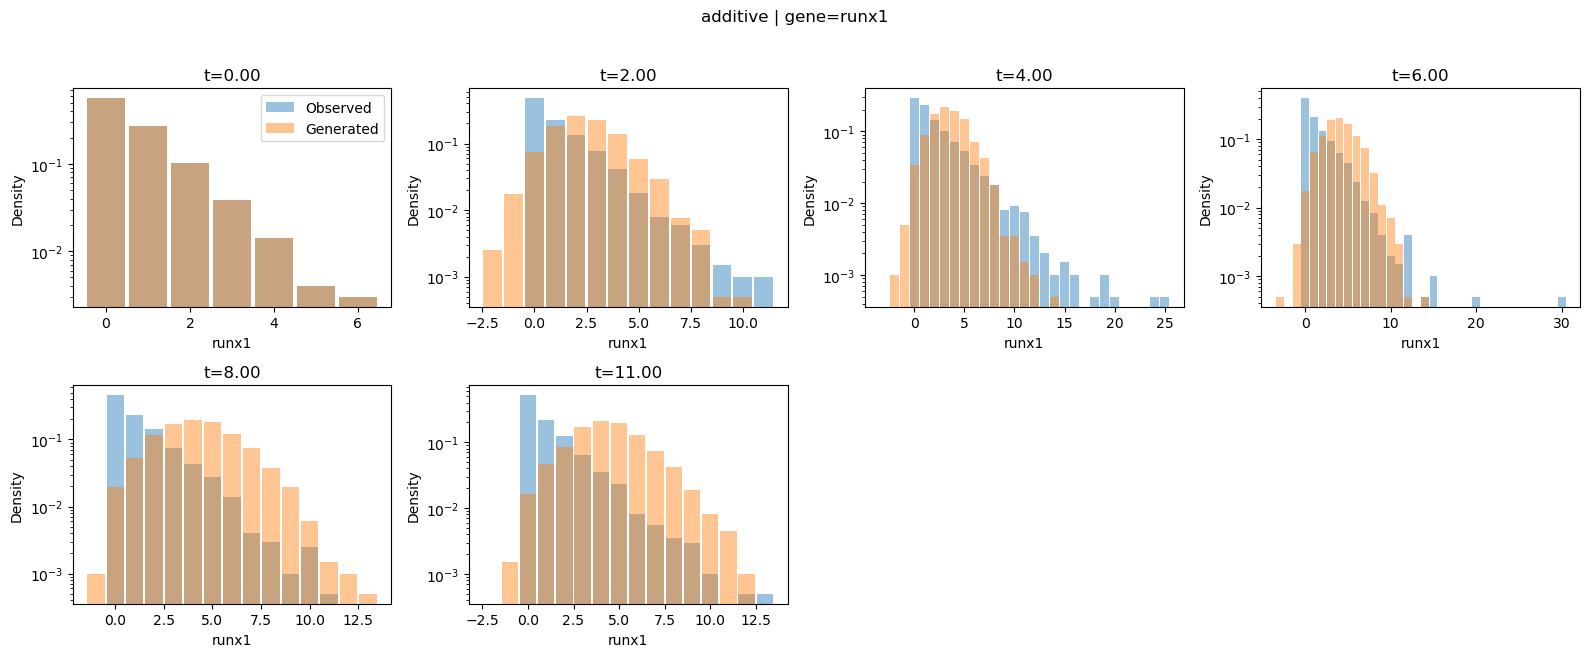

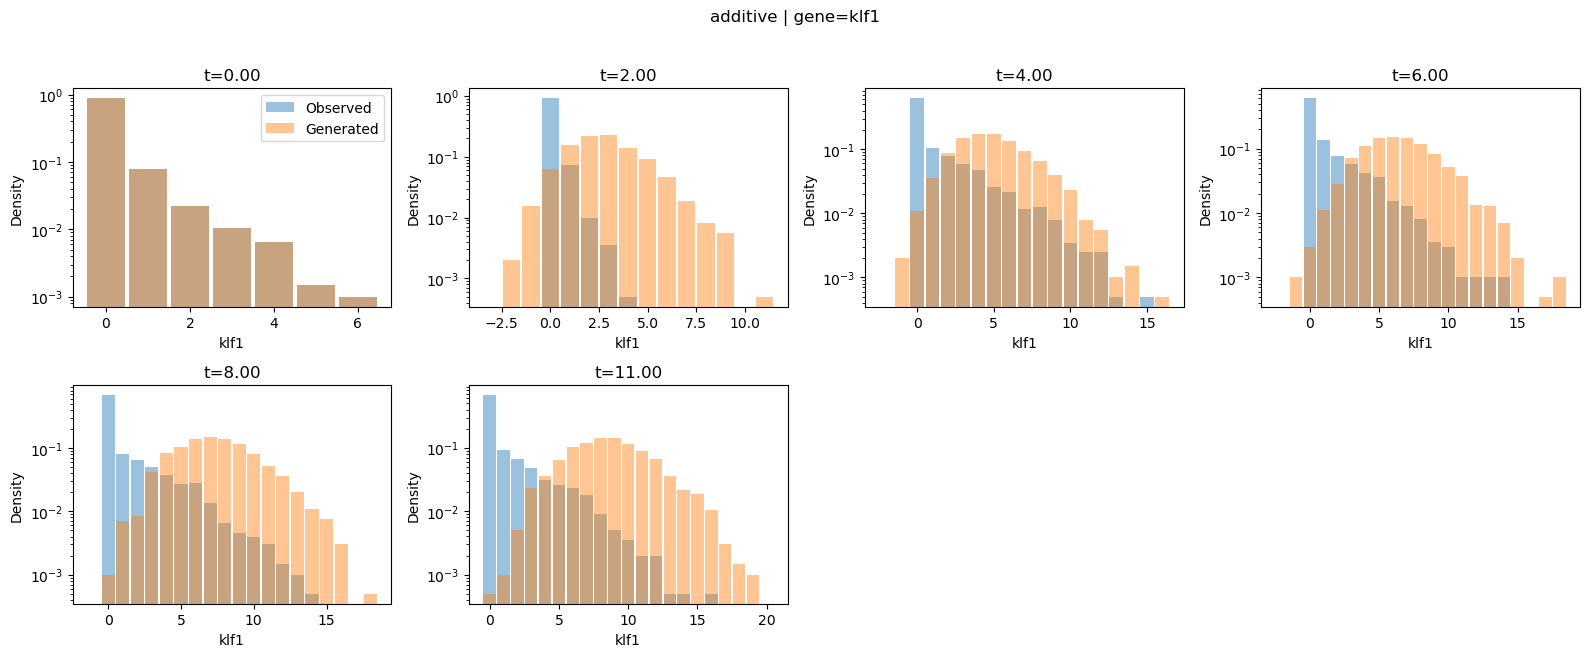

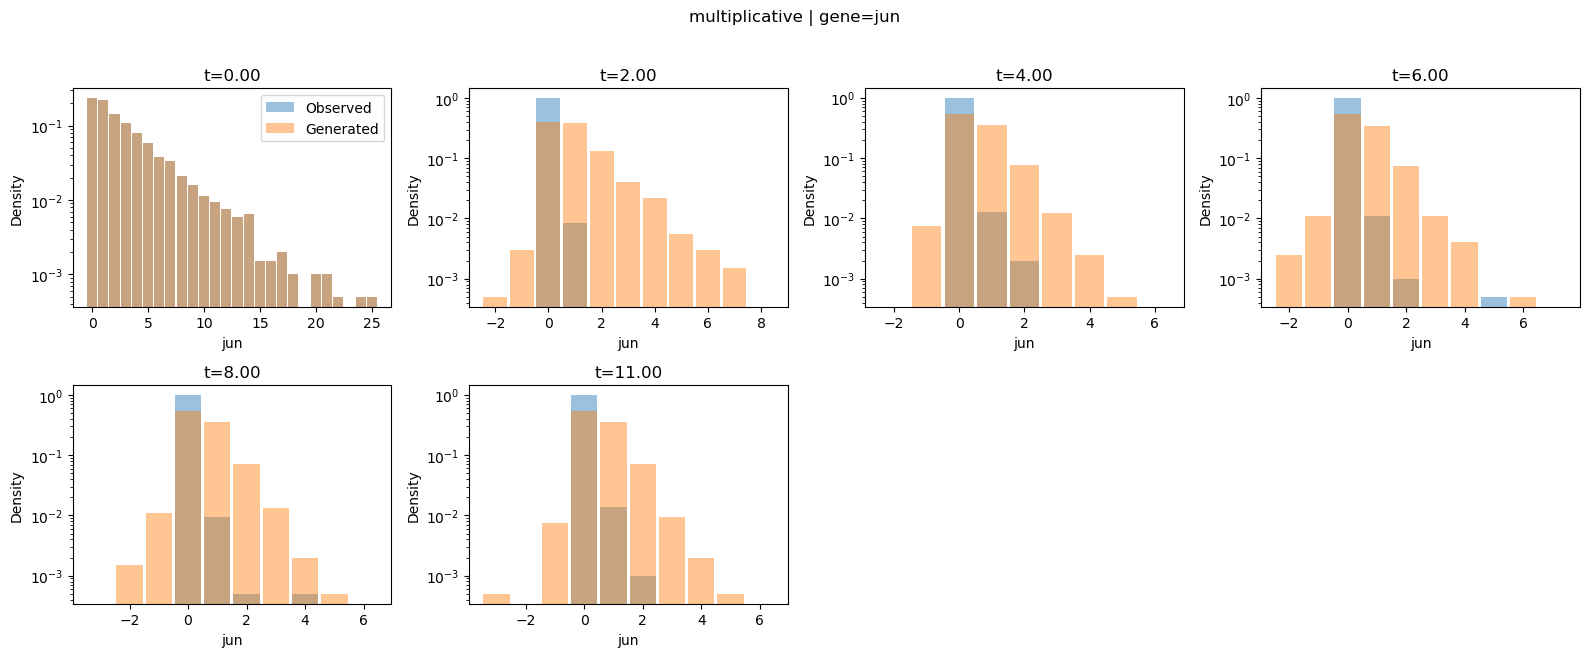

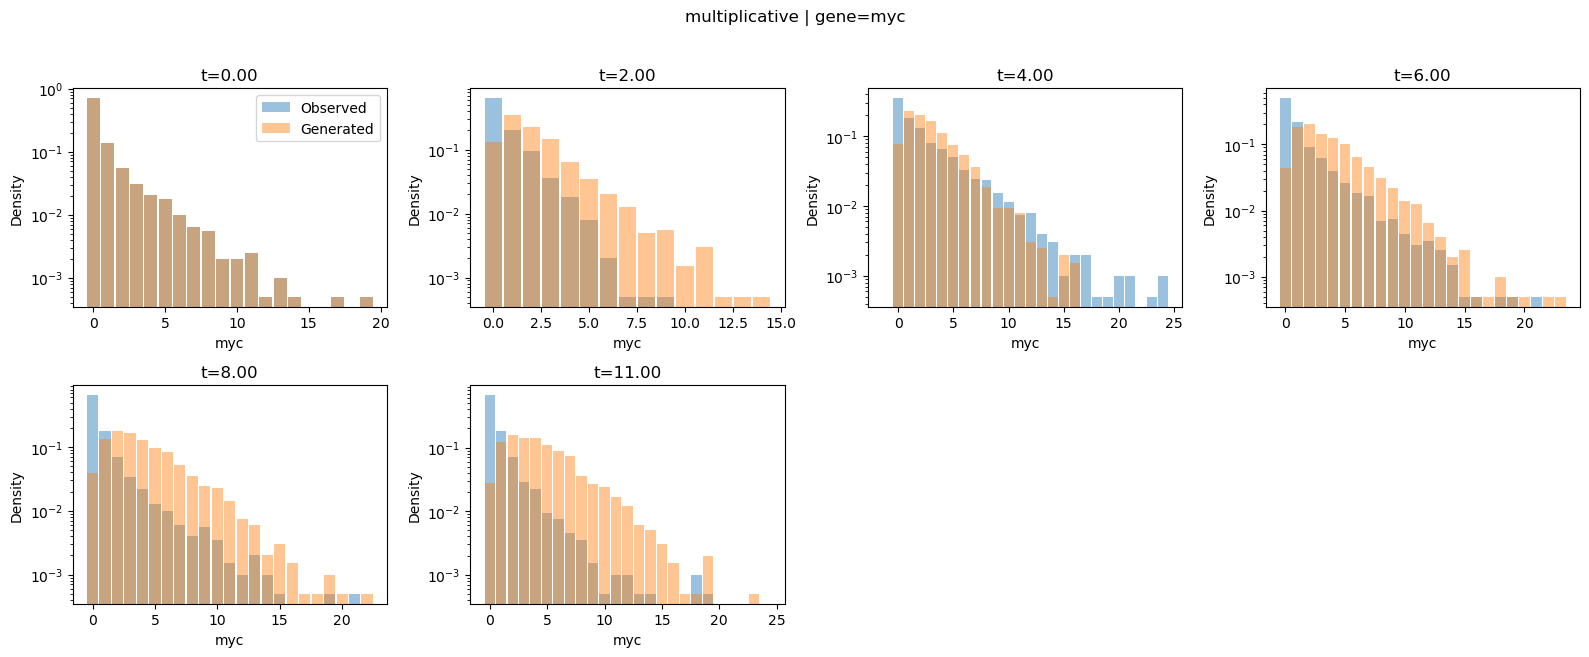

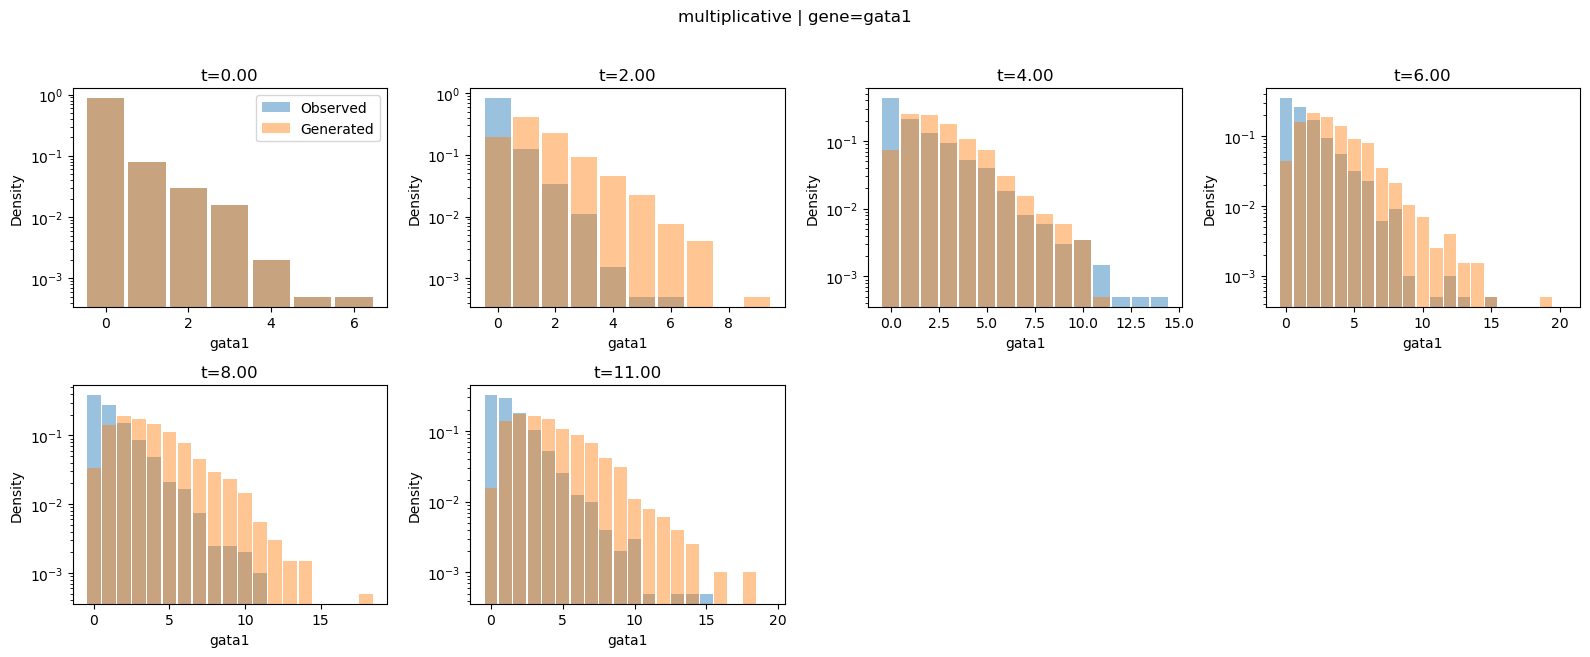

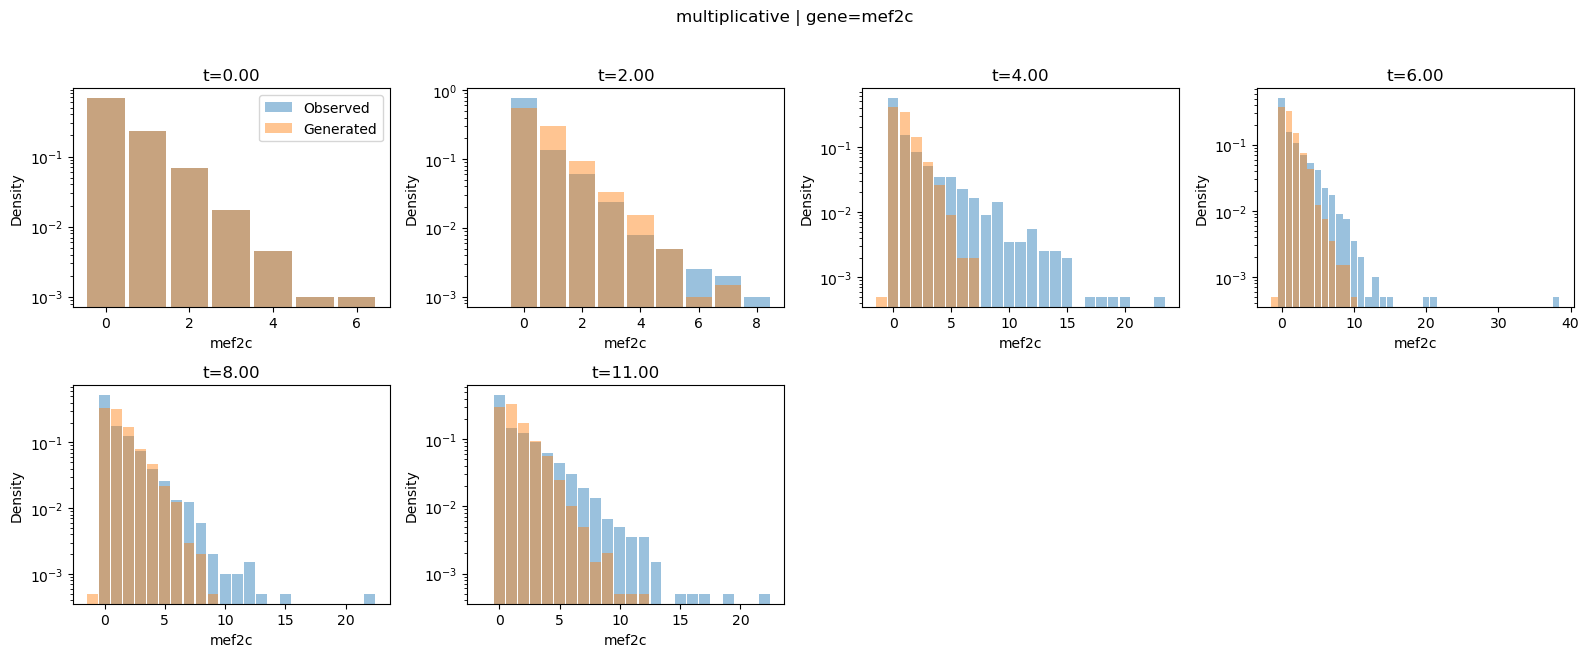

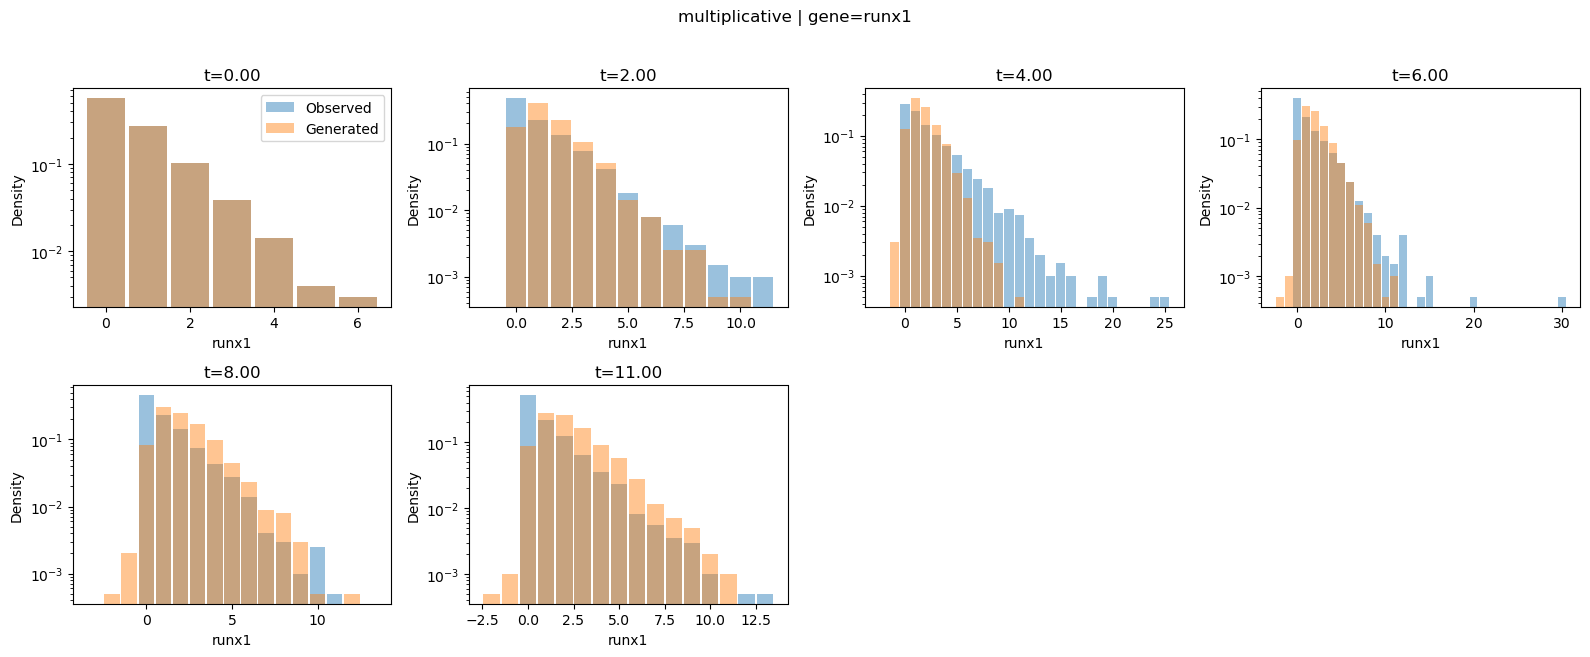

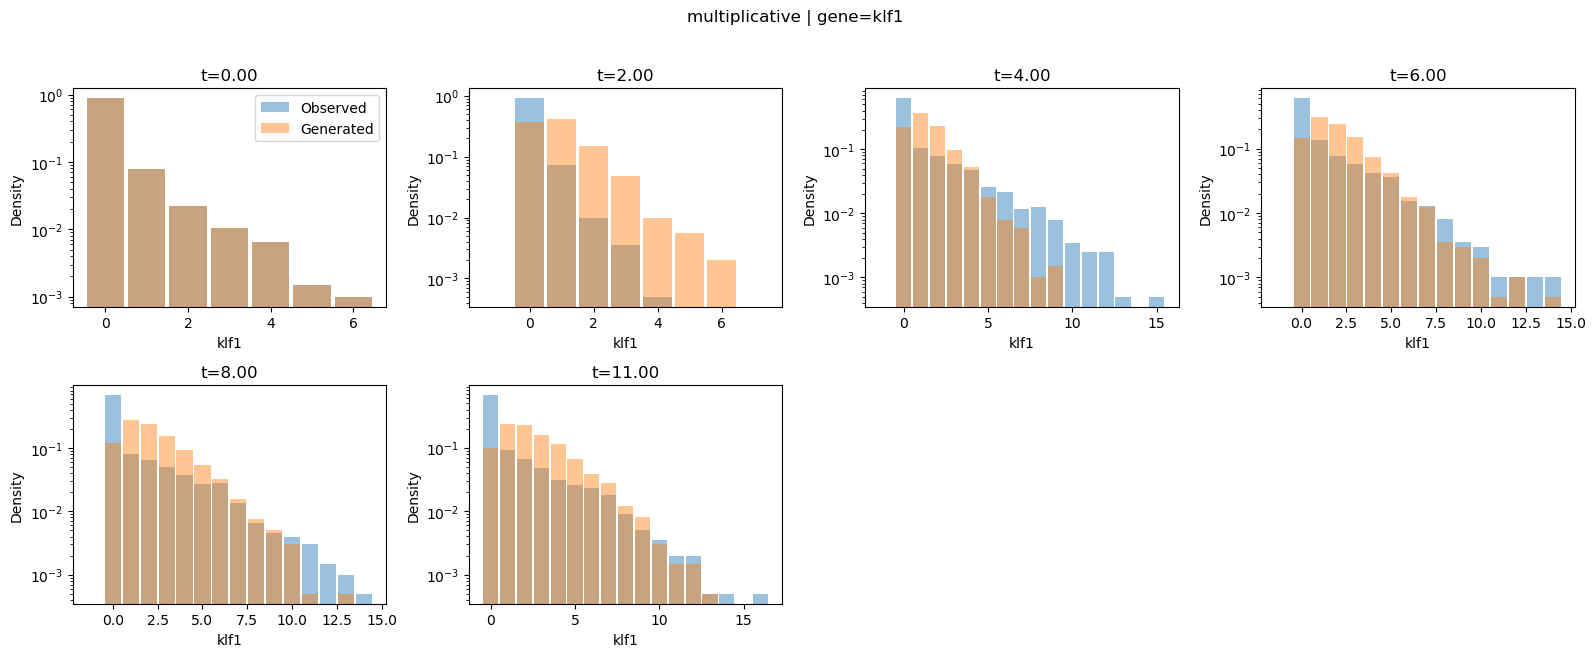

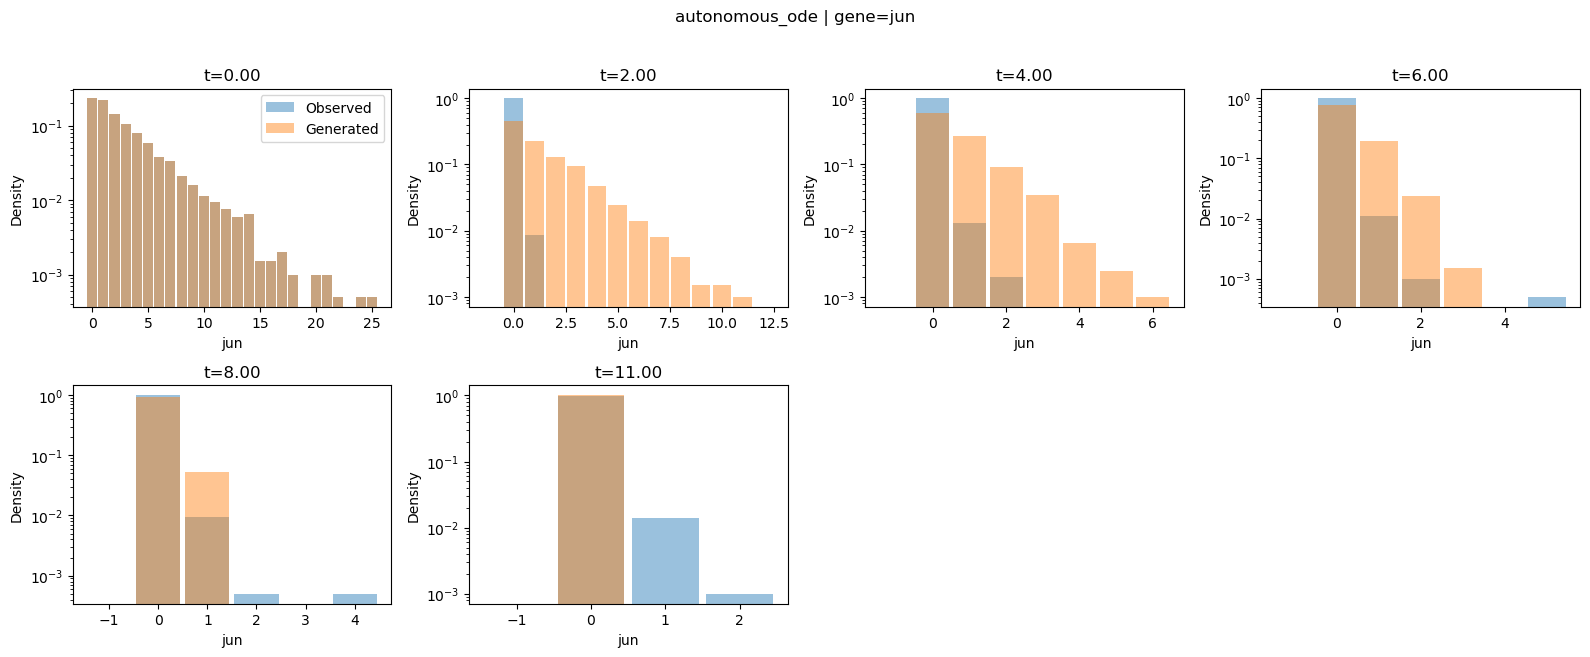

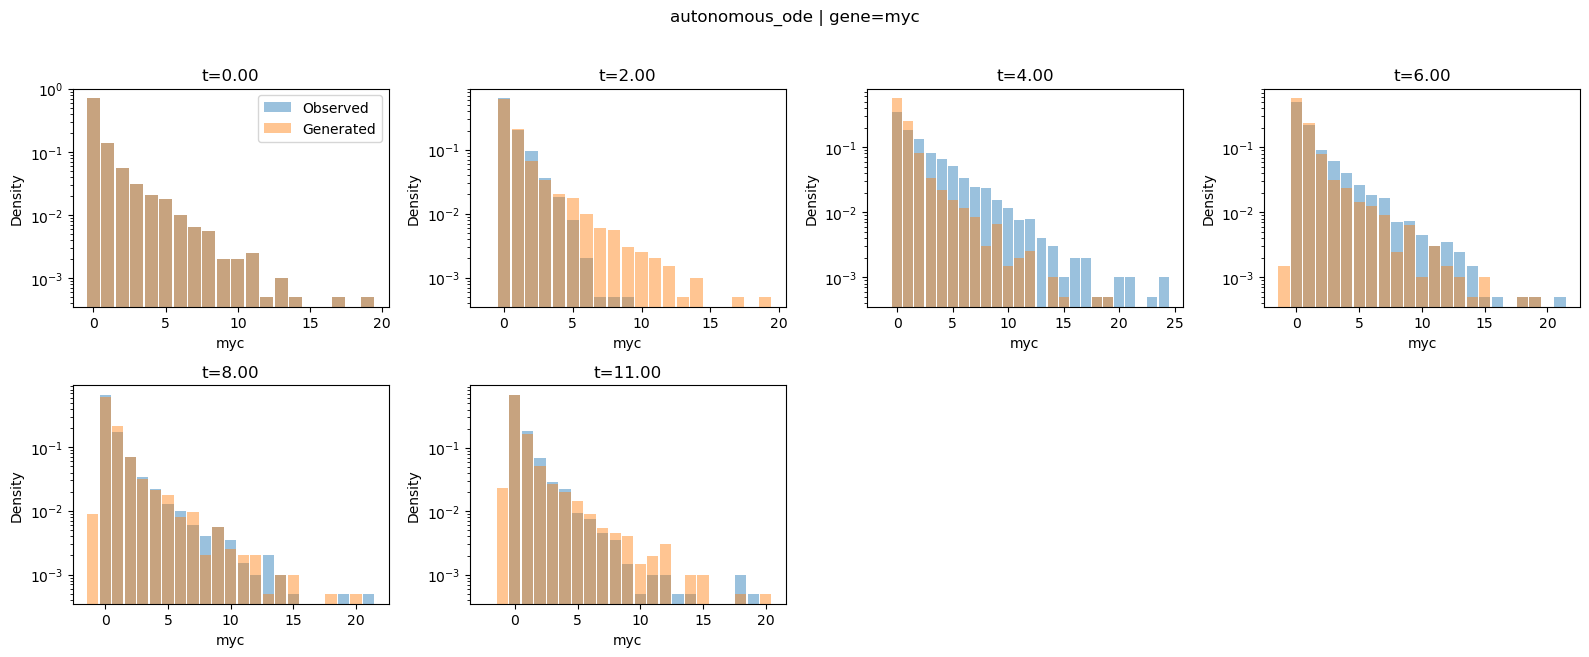

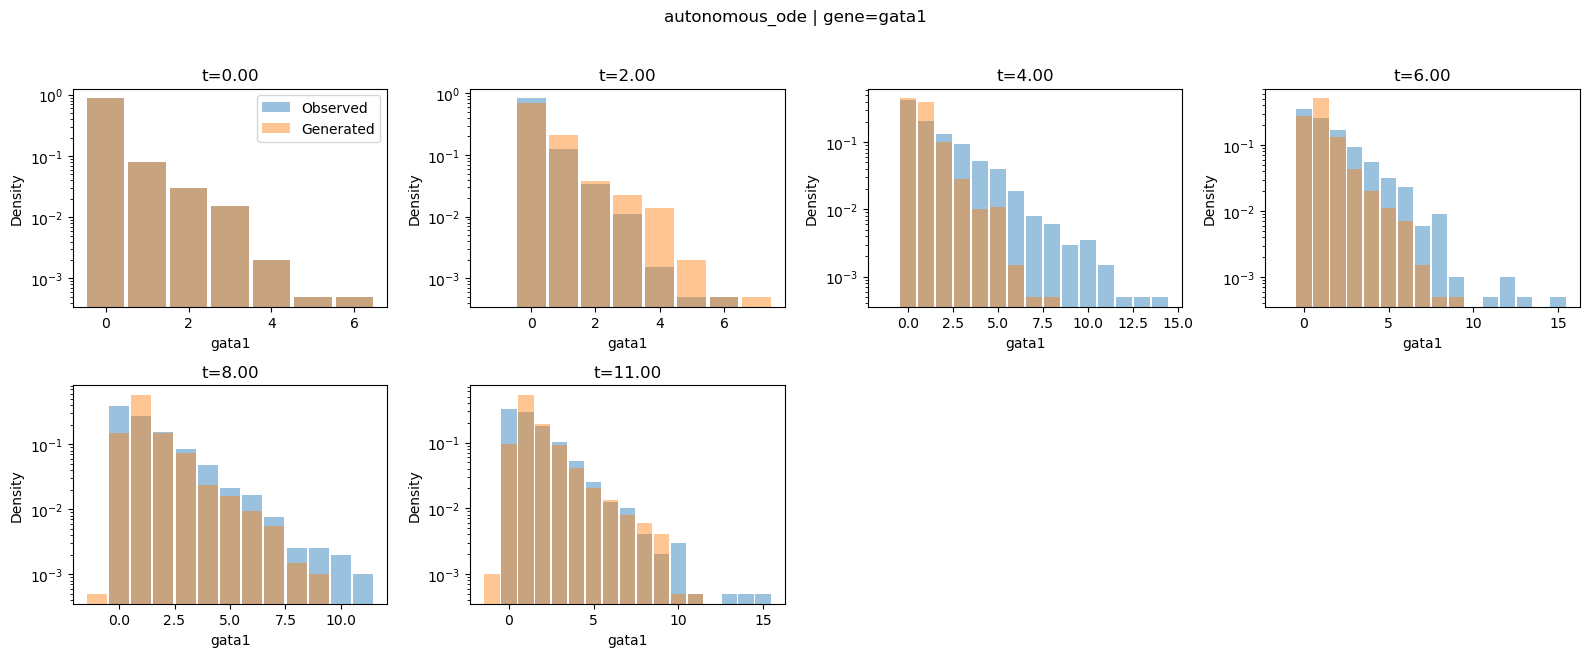

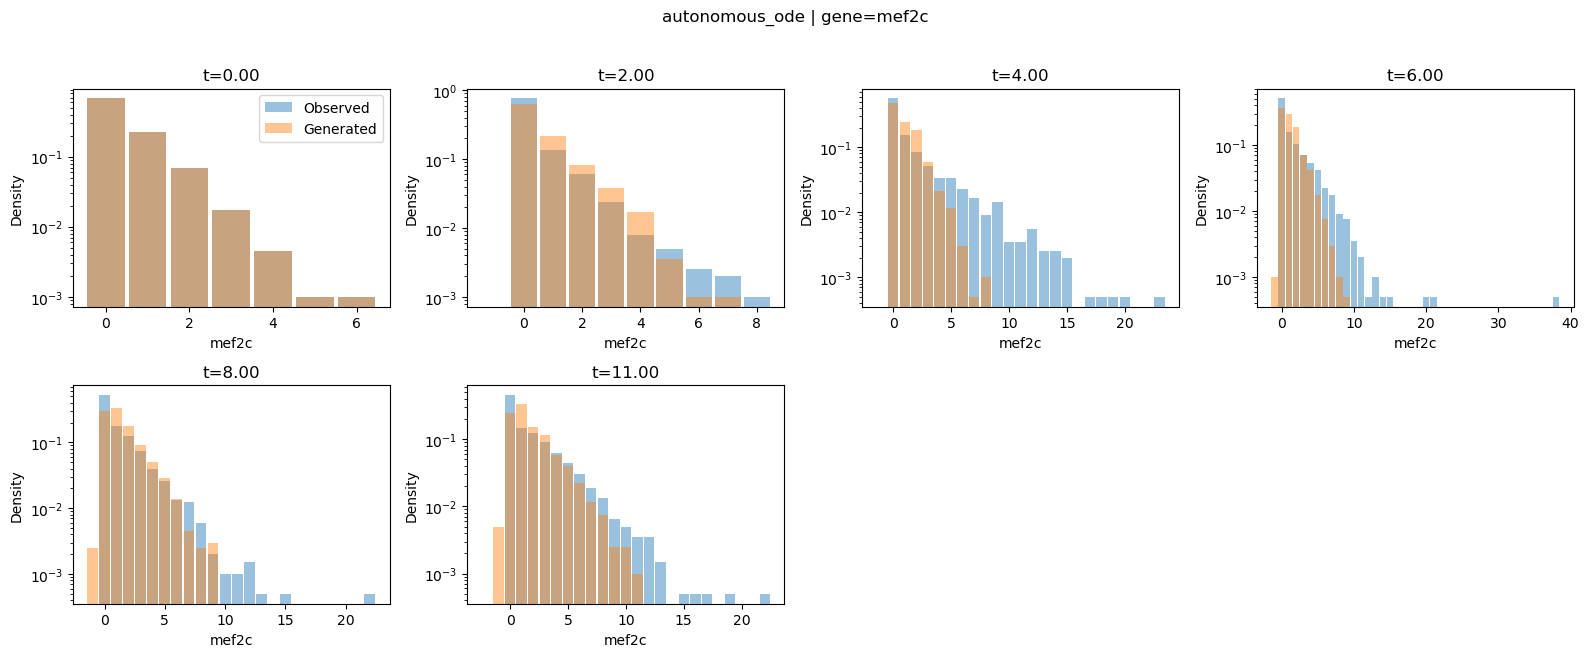

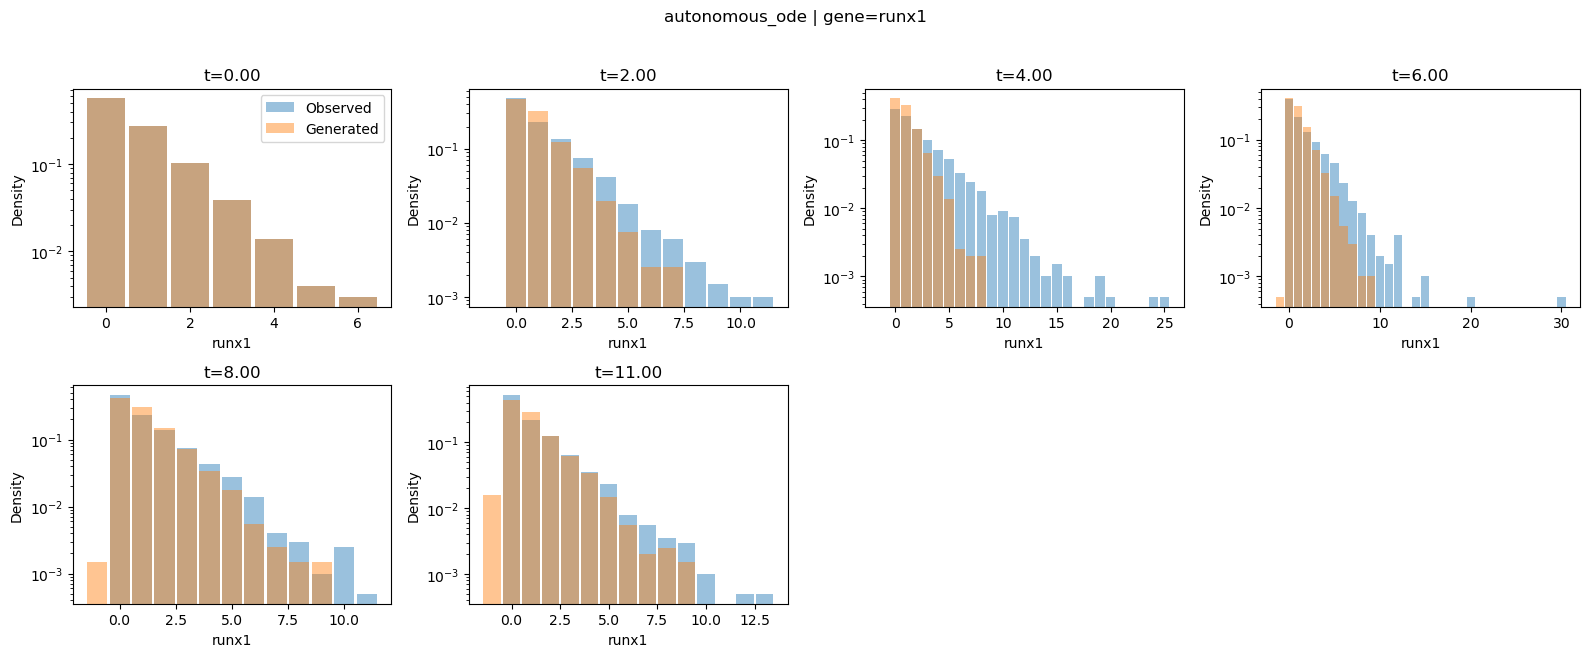

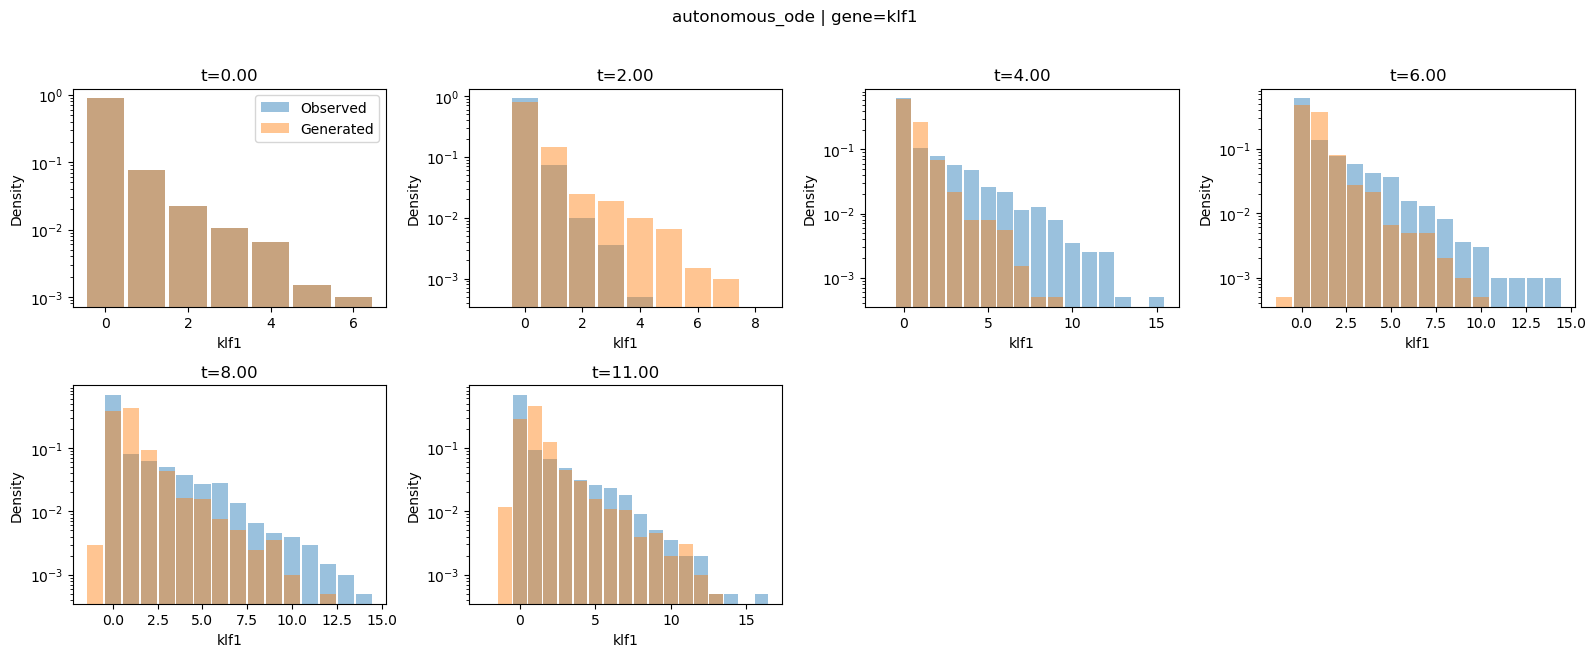

In [9]:
# Compared predicted distributions per model (top-6 most time-varying genes)
import matplotlib.pyplot as plt

t_ex = np.sort(np.unique(X[:, -1]))
t0 = t_ex[0]
X0 = X[np.isclose(X[:, -1], t0)]

# Select genes with largest variation of mean counts across time
mean_by_time = []
for tk in t_ex:
    xk = X[np.isclose(X[:, -1], tk)][:, :ndim]
    mean_by_time.append(np.mean(xk, axis=0))
mean_by_time = np.stack(mean_by_time, axis=0)  # (n_times, ndim)
var_score = np.var(mean_by_time, axis=0)
top6_idx = np.argsort(var_score)[-6:][::-1]
print('Top-6 variable genes:', [genes[i] for i in top6_idx])

for model_name, reg in flow_regs.items():
    gen_by_time = {}
    for k, tk in enumerate(t_ex):
        if k == 0:
            gen_by_time[tk] = X0[:, :ndim]
        else:
            dtk = float(tk - t0)
            gen_by_time[tk] = reg.sample(X0, Dt=dtk, stoch=True, dt=0.01)

    for g in top6_idx:
        ncols = min(4, len(t_ex))
        nrows = int(np.ceil(len(t_ex) / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
        axes = np.atleast_1d(axes).ravel()

        for k, tk in enumerate(t_ex):
            ax = axes[k]
            obs = X[np.isclose(X[:, -1], tk)][:, :ndim]
            gen = gen_by_time[tk]

            ng = min(gen.shape[0], 2000)
            no = min(obs.shape[0], 2000)
            obs1 = obs[:no, g]
            gen1 = gen[:ng, g]

            x_min = int(np.floor(min(obs1.min(), gen1.min())))
            x_max = int(np.ceil(max(obs1.max(), gen1.max())))
            edges = np.arange(x_min - 0.5, x_max + 1.5, 1.0)
            centers = 0.5 * (edges[:-1] + edges[1:])

            obs_counts, _ = np.histogram(obs1, bins=edges)
            gen_counts, _ = np.histogram(gen1, bins=edges)
            obs_density = obs_counts / max(obs_counts.sum(), 1)
            gen_density = gen_counts / max(gen_counts.sum(), 1)

            ax.bar(centers, obs_density, width=0.9, alpha=0.45, label='Observed', align='center')
            ax.bar(centers, gen_density, width=0.9, alpha=0.45, label='Generated', align='center')
            ax.set_yscale('log')
            ax.set_title(f't={tk:.2f}')
            ax.set_xlabel(genes[g])
            ax.set_ylabel('Density')
            if k == 0:
                ax.legend(loc='best')

        for j in range(len(t_ex), len(axes)):
            axes[j].axis('off')

        fig.suptitle(f'{model_name} | gene={genes[g]}', y=1.02)
        plt.tight_layout()
        plt.show()


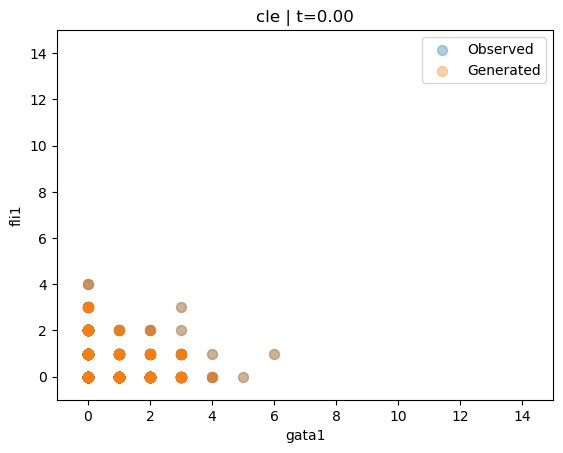

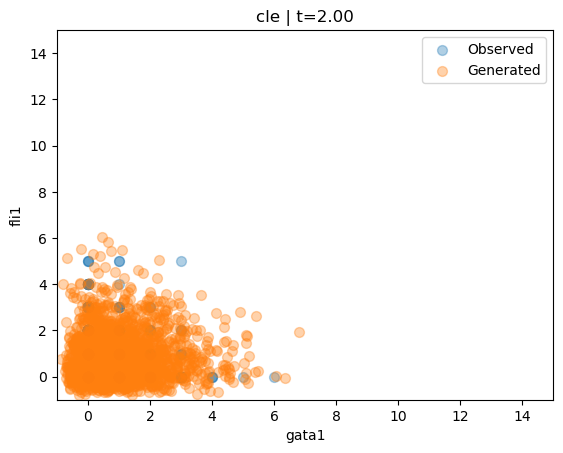

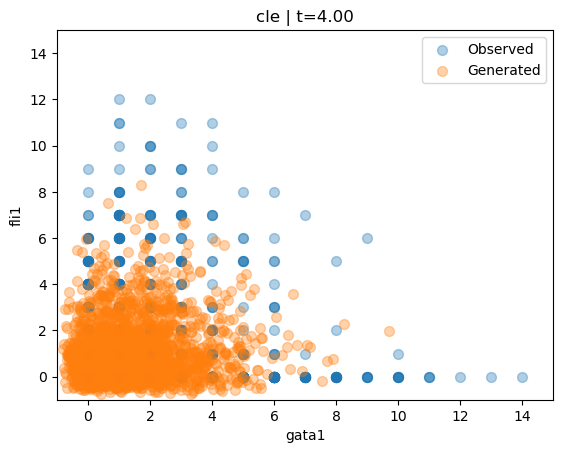

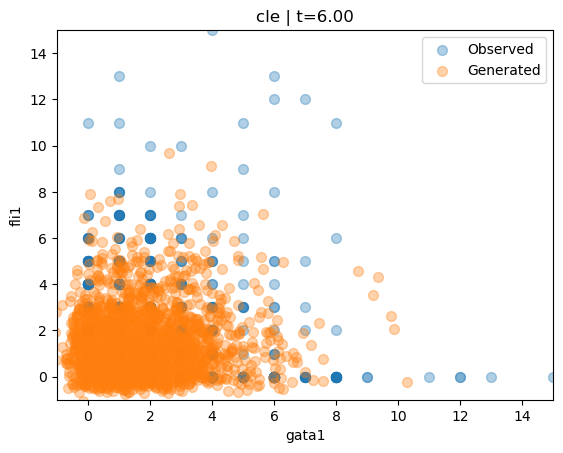

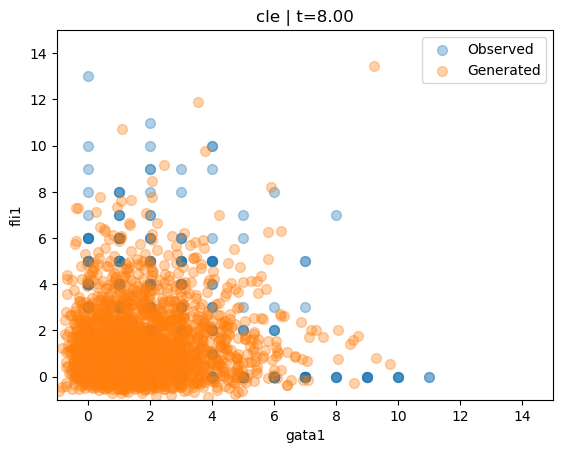

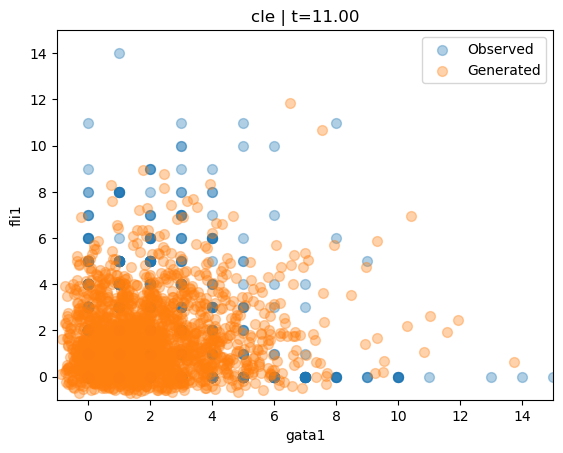

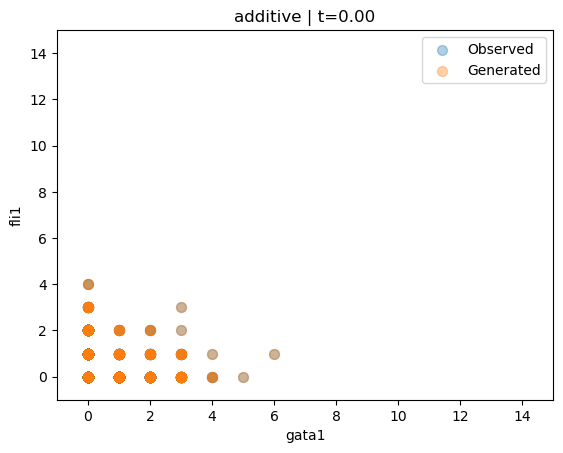

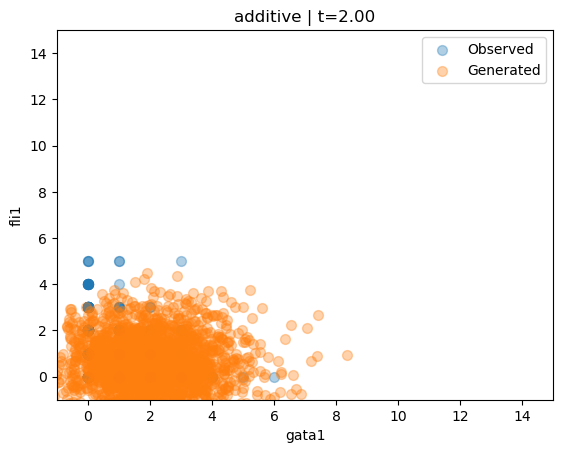

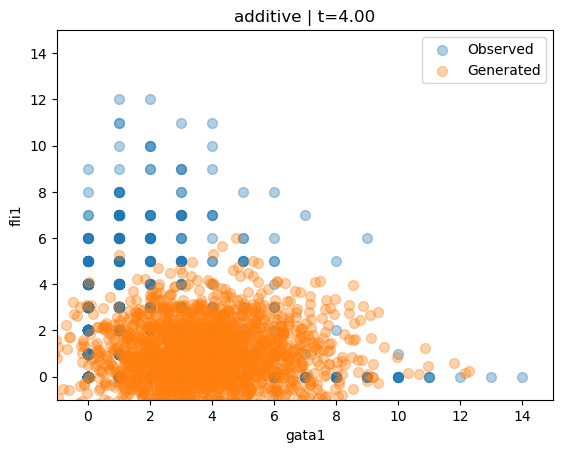

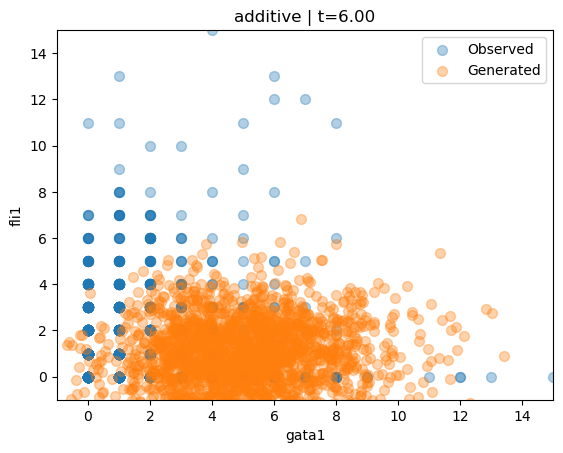

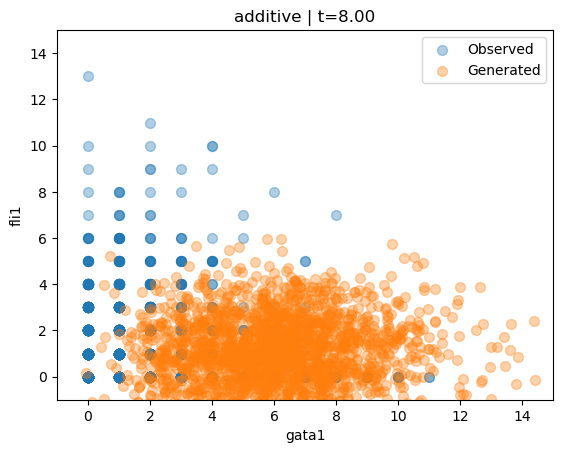

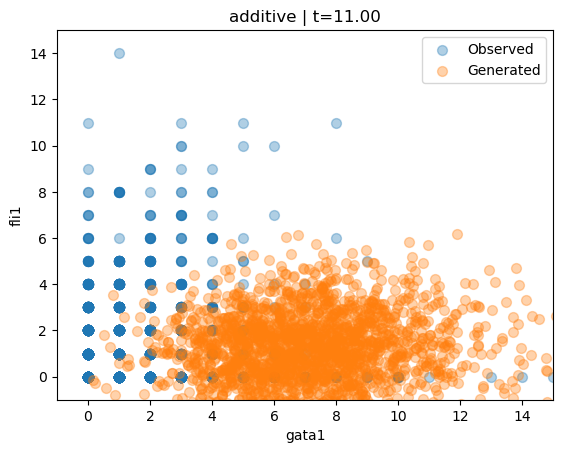

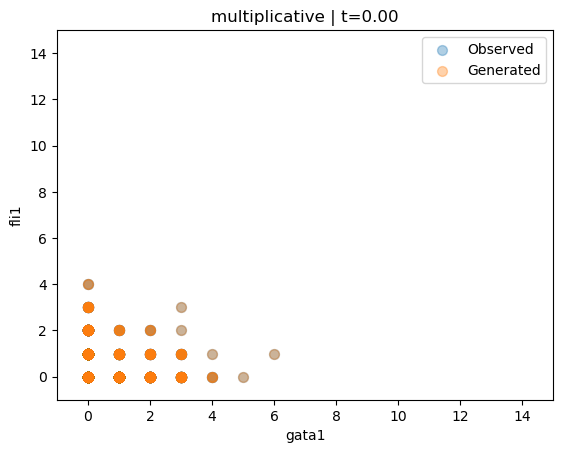

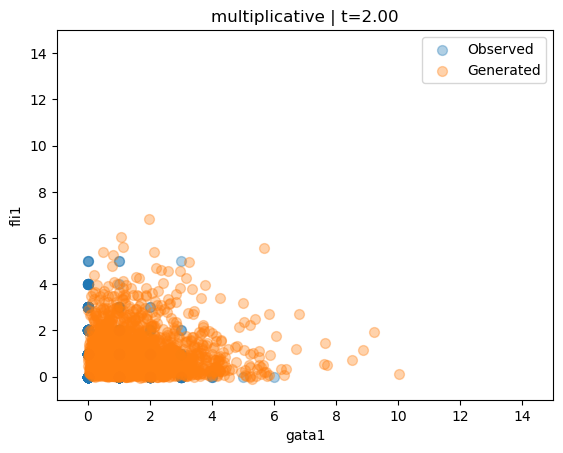

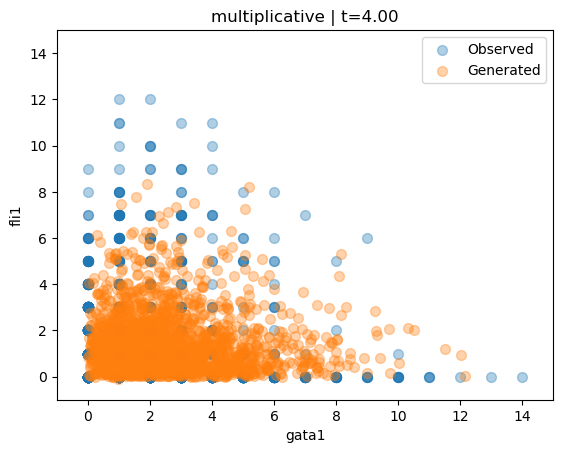

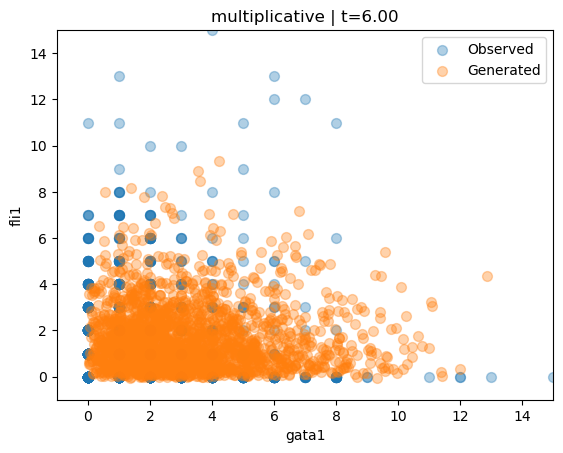

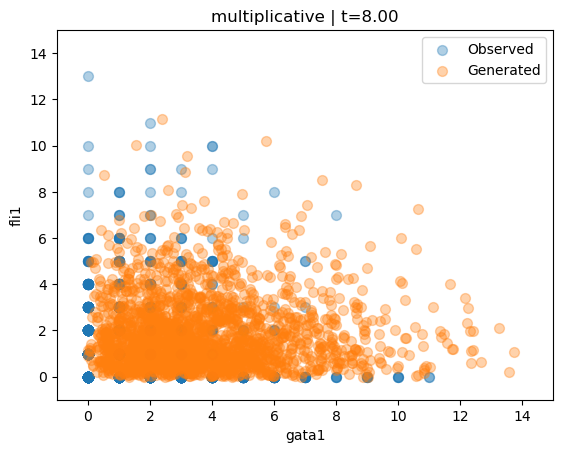

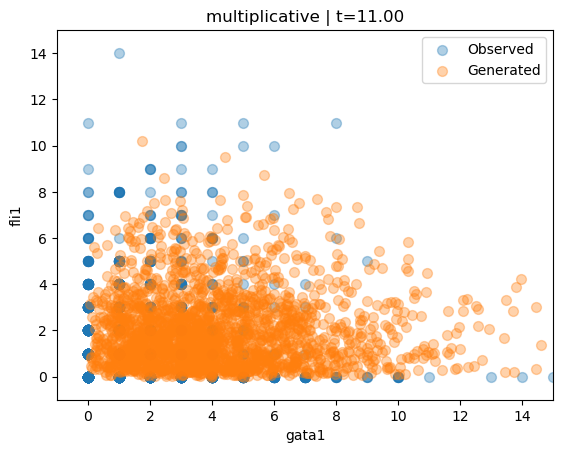

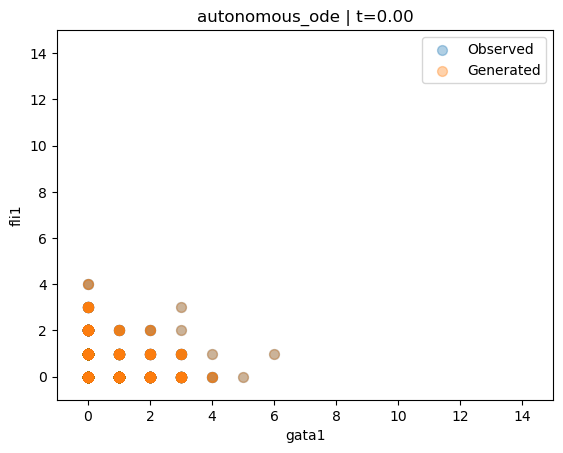

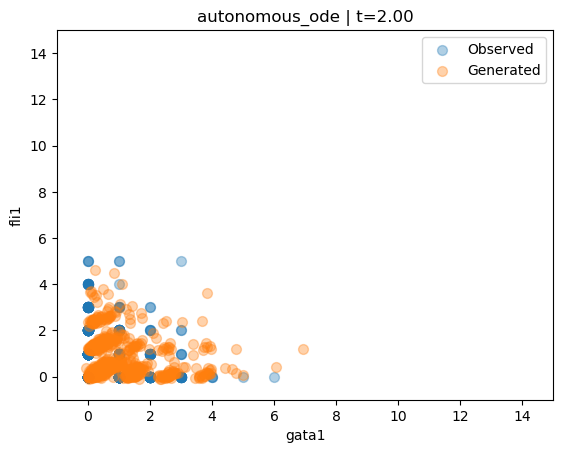

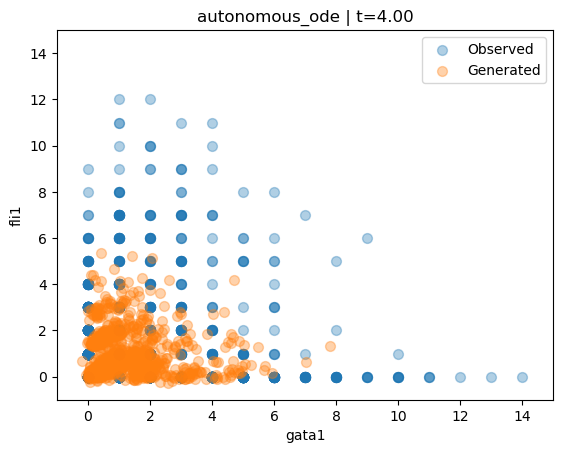

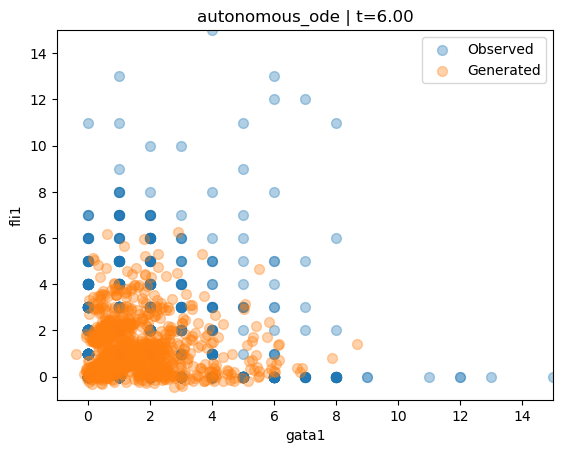

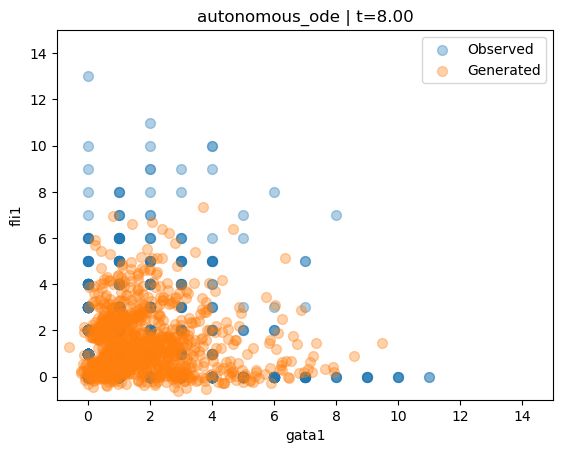

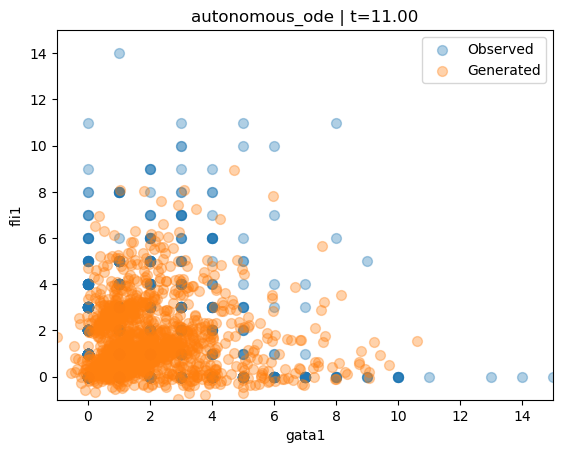

In [10]:
# 2D snapshot overlays (observed vs generated) for each model and time
import matplotlib.pyplot as plt

t_ex = np.sort(np.unique(X[:, -1]))
t0 = t_ex[0]
X0 = X[np.isclose(X[:, -1], t0)]

for model_name, reg in flow_regs.items():
    for k, tk in enumerate(t_ex):
        if k == 0:
            gen = X0[:, :ndim]
        else:
            dtk = float(tk - t0)
            gen = reg.sample(X0, Dt=dtk, stoch=True, dt=0.01)

        obs = X[np.isclose(X[:, -1], tk)][:, :ndim]

        ng = min(gen.shape[0], 2000)
        no = min(obs.shape[0], 2000)

        fig, ax = plt.subplots()
        ax.scatter(obs[:no, 0], obs[:no, 1], s=50, alpha=0.35, label='Observed')
        ax.scatter(gen[:ng, 0], gen[:ng, 1], s=50, alpha=0.35, label='Generated')
        ax.set_title(f'{model_name} | t={tk:.2f}')
        ax.set_xlabel(genes[0])
        ax.set_ylabel(genes[1])
        ax.legend(loc='best')
        ax.set_xlim(xmin = -1, xmax = 15)
        ax.set_ylim(ymin=-1, ymax=15)
        plt.show()


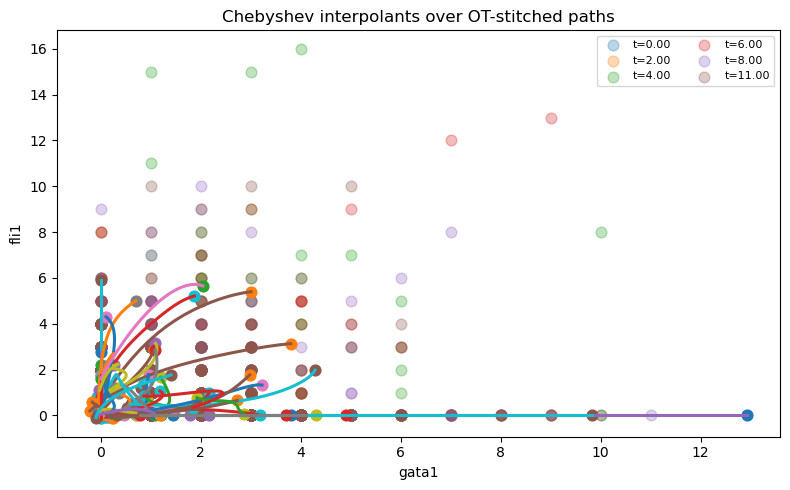

In [11]:
# Chebyshev interpolants connecting successive snapshot distributions
from pfi.flow.interpolants import MMOT_trajectories, ChebyshevInterpolant
from pfi.utils.data import snapshots_from_X
import matplotlib.pyplot as plt

snaps, _ = snapshots_from_X(X)
dist, batch_ot_samples = MMOT_trajectories(snaps, nb=nmb, device=device)


times_fit = np.sort(np.unique(X[:, -1]))
n_eval = 20
nodes_fit = torch.tensor(times_fit, dtype=torch.float32, device=device)[None, :].repeat(batch_ot_samples.shape[1], 1)
nodes_eval = torch.tensor(np.linspace(times_fit[0], times_fit[-1], n_eval), dtype=torch.float32, device=device)[None, :].repeat(batch_ot_samples.shape[1], 1)

# shape for interpolant: (nsamples, nsnaps, ndim)
paths = torch.permute(batch_ot_samples[:, :, :ndim], (1, 0, 2))

interp = ChebyshevInterpolant(device=device, reg_=0.3)
interp.fit(nodes_fit, paths)
x_interp, _ = interp.predict(nodes_eval)
x_interp = x_interp.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(8, 5))
for k, tk in enumerate(times_fit):
    xk = X[np.isclose(X[:, -1], tk)]
    idx = np.arange(xk.shape[0])
    np.random.shuffle(idx)
    sel = idx[:400] if xk.shape[0] >= 400 else idx
    ax.scatter(xk[sel, 0], xk[sel, 1], s=60, alpha=0.3, label=f't={tk:.2f}')

n_paths = 60
for i in range(n_paths):
    ax.plot(x_interp[i, :, 0], x_interp[i, :, 1], linewidth=2.2)
    ax.scatter(x_interp[i, :, 0][[0, -1]], x_interp[i, :, 1][[0, -1]], s=60)

ax.set_title('Chebyshev interpolants over OT-stitched paths')
ax.set_xlabel(genes[0])
ax.set_ylabel(genes[1])
ax.legend(loc='best', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


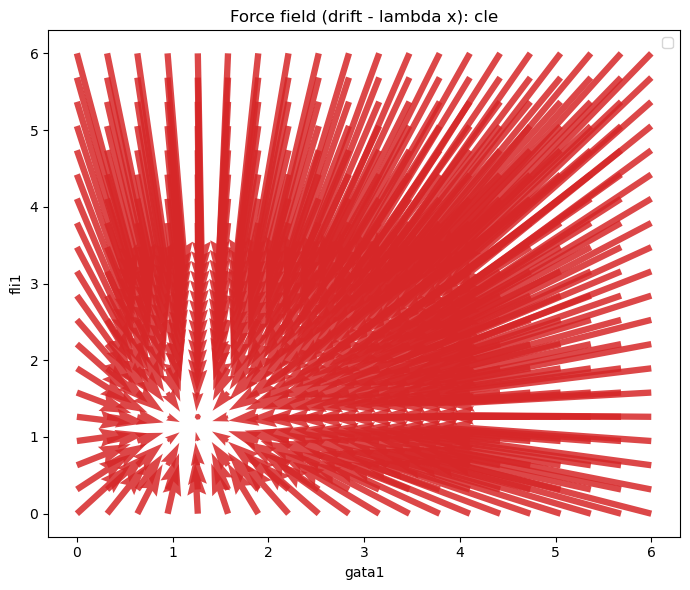

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


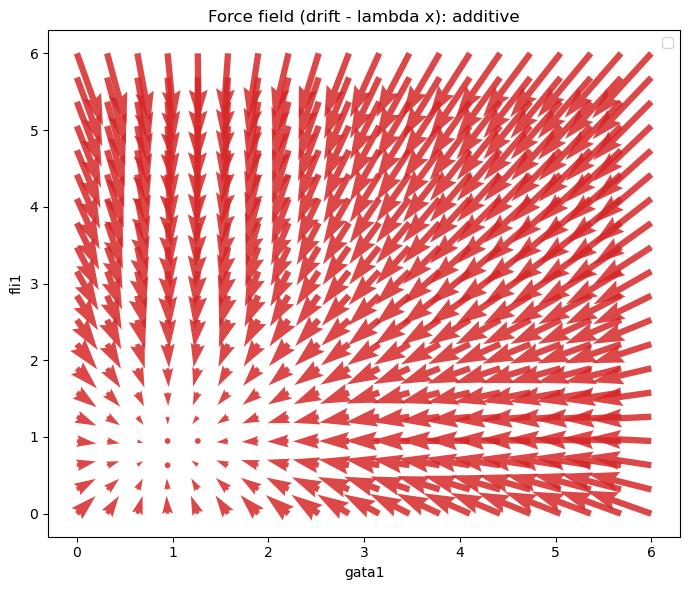

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


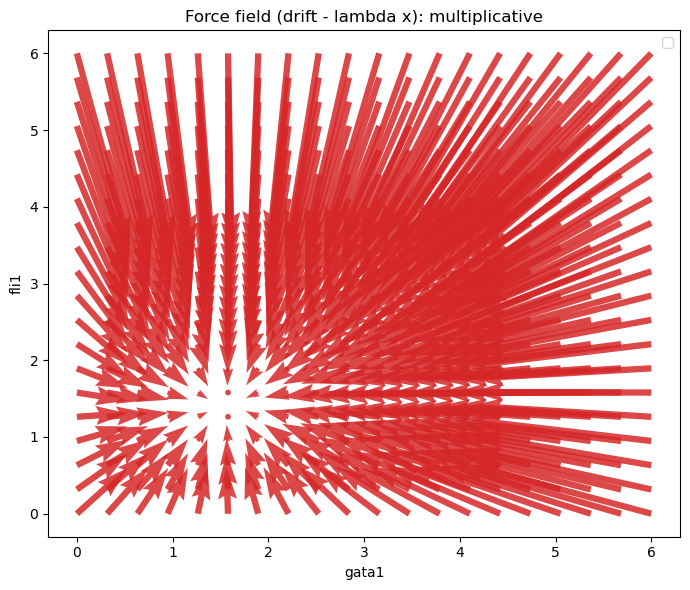

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


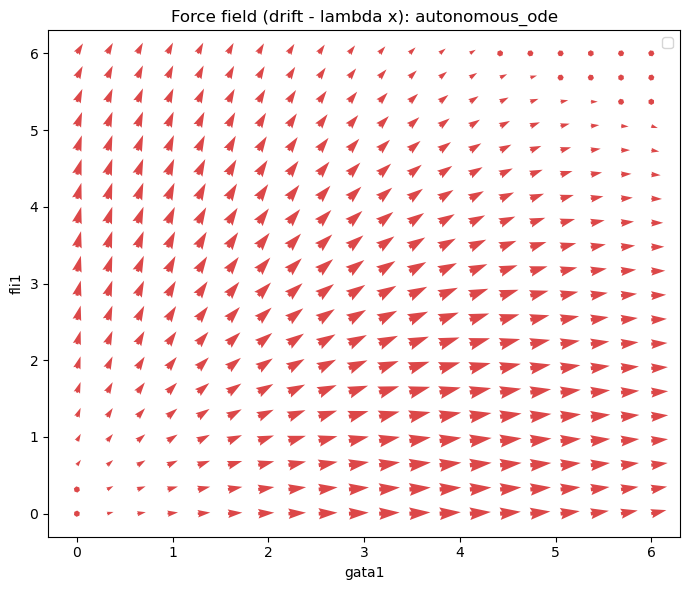

In [12]:
# Force field: drift - lambda*x on a larger grid over all data
import numpy as np
import torch
import matplotlib.pyplot as plt

times_fit = np.sort(np.unique(X[:, -1]))
t0 = times_fit[0]

# Use all data to define a wider plotting domain
x1_min, x1_max = np.quantile(X[:, 0], [0.001, 0.999])
x2_min, x2_max = np.quantile(X[:, 1], [0.001, 0.999])
pad1 = 0.08 * (x1_max - x1_min)
pad2 = 0.08 * (x2_max - x2_min)
x1_min, x1_max = x1_min - pad1, x1_max + pad1
x2_min, x2_max = x2_min - pad2, x2_max + pad2

nq = 20
g1 = np.linspace(0, 6, nq)
g2 = np.linspace(0, 6, nq)
G1, G2 = np.meshgrid(g1, g2)

Xgrid = np.zeros((G1.size, ndim + 1), dtype=np.float32)
Xgrid[:, 0] = G1.ravel()
Xgrid[:, 1] = G2.ravel()
if ndim > 2:
    Xgrid[:, 2:ndim] = np.median(X[:, 2:ndim], axis=0)[None, :]
Xgrid[:, -1] = t0

for model_name, reg in flow_regs.items():
    model = reg.model_
    x_in = torch.tensor(Xgrid, dtype=torch.float32, device=reg.device)
    xt = x_in[:, :reg.Ndim_]
    with torch.no_grad():
        drift = model.net(xt)
        force = drift - model.lx * xt
    force_np = force.detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(7, 6))
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    idx = idx[:4000] if X.shape[0] > 4000 else idx
    #ax.scatter(X[idx, 0], X[idx, 1], s=6, alpha=0.18, color='gray', label='all data')

    ax.quiver(
        Xgrid[:, 0], Xgrid[:, 1],
        force_np[:, 0], force_np[:, 1],
        color='tab:red', alpha=0.85, scale=8, width=0.01
    )

    ax.set_title(f'Force field (drift - lambda x): {model_name}')
    ax.set_xlabel(genes[0])
    ax.set_ylabel(genes[1])
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()


In [13]:
force

tensor([[ 5.7562e-02,  2.6175e-02,  4.0535e-02,  ...,  8.2360e-03,
          8.9213e-05,  4.4142e-02],
        [ 8.1579e-02,  2.2247e-02,  3.7619e-02,  ...,  6.6959e-03,
          1.0021e-03,  4.3529e-02],
        [ 1.0684e-01,  1.9190e-02,  3.5217e-02,  ...,  5.4468e-03,
          2.0824e-03,  4.3342e-02],
        ...,
        [ 4.8467e-02, -2.4626e-02,  5.6774e-02,  ...,  1.1312e-01,
          4.8905e-02,  1.8249e-01],
        [ 3.7193e-02, -4.3583e-02,  6.5536e-02,  ...,  1.1846e-01,
          4.9880e-02,  1.8349e-01],
        [ 2.3860e-02, -6.2962e-02,  7.5043e-02,  ...,  1.2400e-01,
          5.0775e-02,  1.8485e-01]], device='cuda:0')